In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import re
import datetime

import matplotlib as mpl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy as cart
import scipy.stats as stats
import random


from CE_Functions import *
from ClimateModesForCEs import *
from PlottingForCEs import *

mpl.rcParams['figure.dpi'] = 300

Call in Files, Sort the Files so they match the CDVP files, compute averages for temperature and precipitation, compute averages for modes

In [2]:
## CALL IN FILES ## 
cesm_trefht_dir = "../CESM_data/TREFHT/2mtemptaketwo/"
cesm_trefht_files = sorted(glob.glob(f"{cesm_trefht_dir}*.nc"))

cesm_prect_dir = "../CESM_data/PRECT/prect_data_take_two/"
cesm_prect_files = sorted(glob.glob(f"{cesm_prect_dir}*.nc"))

cesm_ts_dir = "../CESM_data/TS/ts_data2/"
cesm_ts_files = sorted(glob.glob(f"{cesm_ts_dir}*.nc"))

cesm_psl_dir = "../CESM_data/SlP/SLP_monthly_data/"
cesm_psl_files = sorted(glob.glob(f"{cesm_psl_dir}*.nc"))

cdvp_dir = '/Users/aedwyer/Documents/CESM_data/cesm2-lens_1850-2100.cvdp_data/CDVP_Members/'
cdvp_files = sorted(glob.glob(f"{cdvp_dir}*.nc"))


## SORT FILENAMES ##

# Function to extract the numerical value from the filename
def extract_number(filename):
    match = re.search(r'\d{3,4}\.\d{3}', filename)
    if match:
        return tuple(map(int, match.group().split('.')))
    return (0, 0)  # Default value if no match found

# Sort filenames based on the extracted numerical value
sorted_filenames_trefht = sorted(cesm_trefht_files, key = extract_number)
sorted_filesnames_prect = sorted(cesm_prect_files, key = extract_number)
sorted_filenames_ts = sorted(cesm_ts_files, key = extract_number)

## COMPUTE AVERAGES TO REMOVE EXTERNAL FORCING
trefht_avg_past, prect_avg_past, ts_avg_past = ensemble_mean(cesm_trefht_files, cesm_prect_files, cesm_ts_files, 0, 1212) # 1080-2088 for 1940-2024
trefht_avg_future, prect_avg_future, ts_avg_future = ensemble_mean(cesm_trefht_files, cesm_prect_files, cesm_ts_files, 1800, 3012)


## CALL IN FUTURE CE CALCULATION (INERNAL VARIABILITY, POOLED QUANTILE, SORTED FILES) ##
## PUT INTO LIST ##
ces_qpm_sorted_future = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/QuantilesPerMonth_90T_10P_2000_2100_SortedFiles_PooledQuant.nc')

# put all binary members into one list to call later
CES_all_locations_binary_future = []
for mem in ces_qpm_sorted_future['member']:
    mem_select = ces_qpm_sorted_future.sel(member = mem)
    # pick out one location
    CES_all_locations_binary_future.append(mem_select['TREFHT'])

## CALL IN PAST CE CALCULATION (INTERAL VARIABILITY, POOLED QUANTILE, SORTED FILES) ##
## PUT INTO LIST ##
ces_qpm_sorted_past = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/QuantilesPerMonth_90T_10P_1850_1950_SortedFiles_PooledQuant.nc')

# put all binary members into one list to call later
CES_all_locations_binary_past = []
for mem in ces_qpm_sorted_past['member']:
    mem_select = ces_qpm_sorted_past.sel(member = mem)
    # pick out one location
    CES_all_locations_binary_past.append(mem_select['TREFHT'])


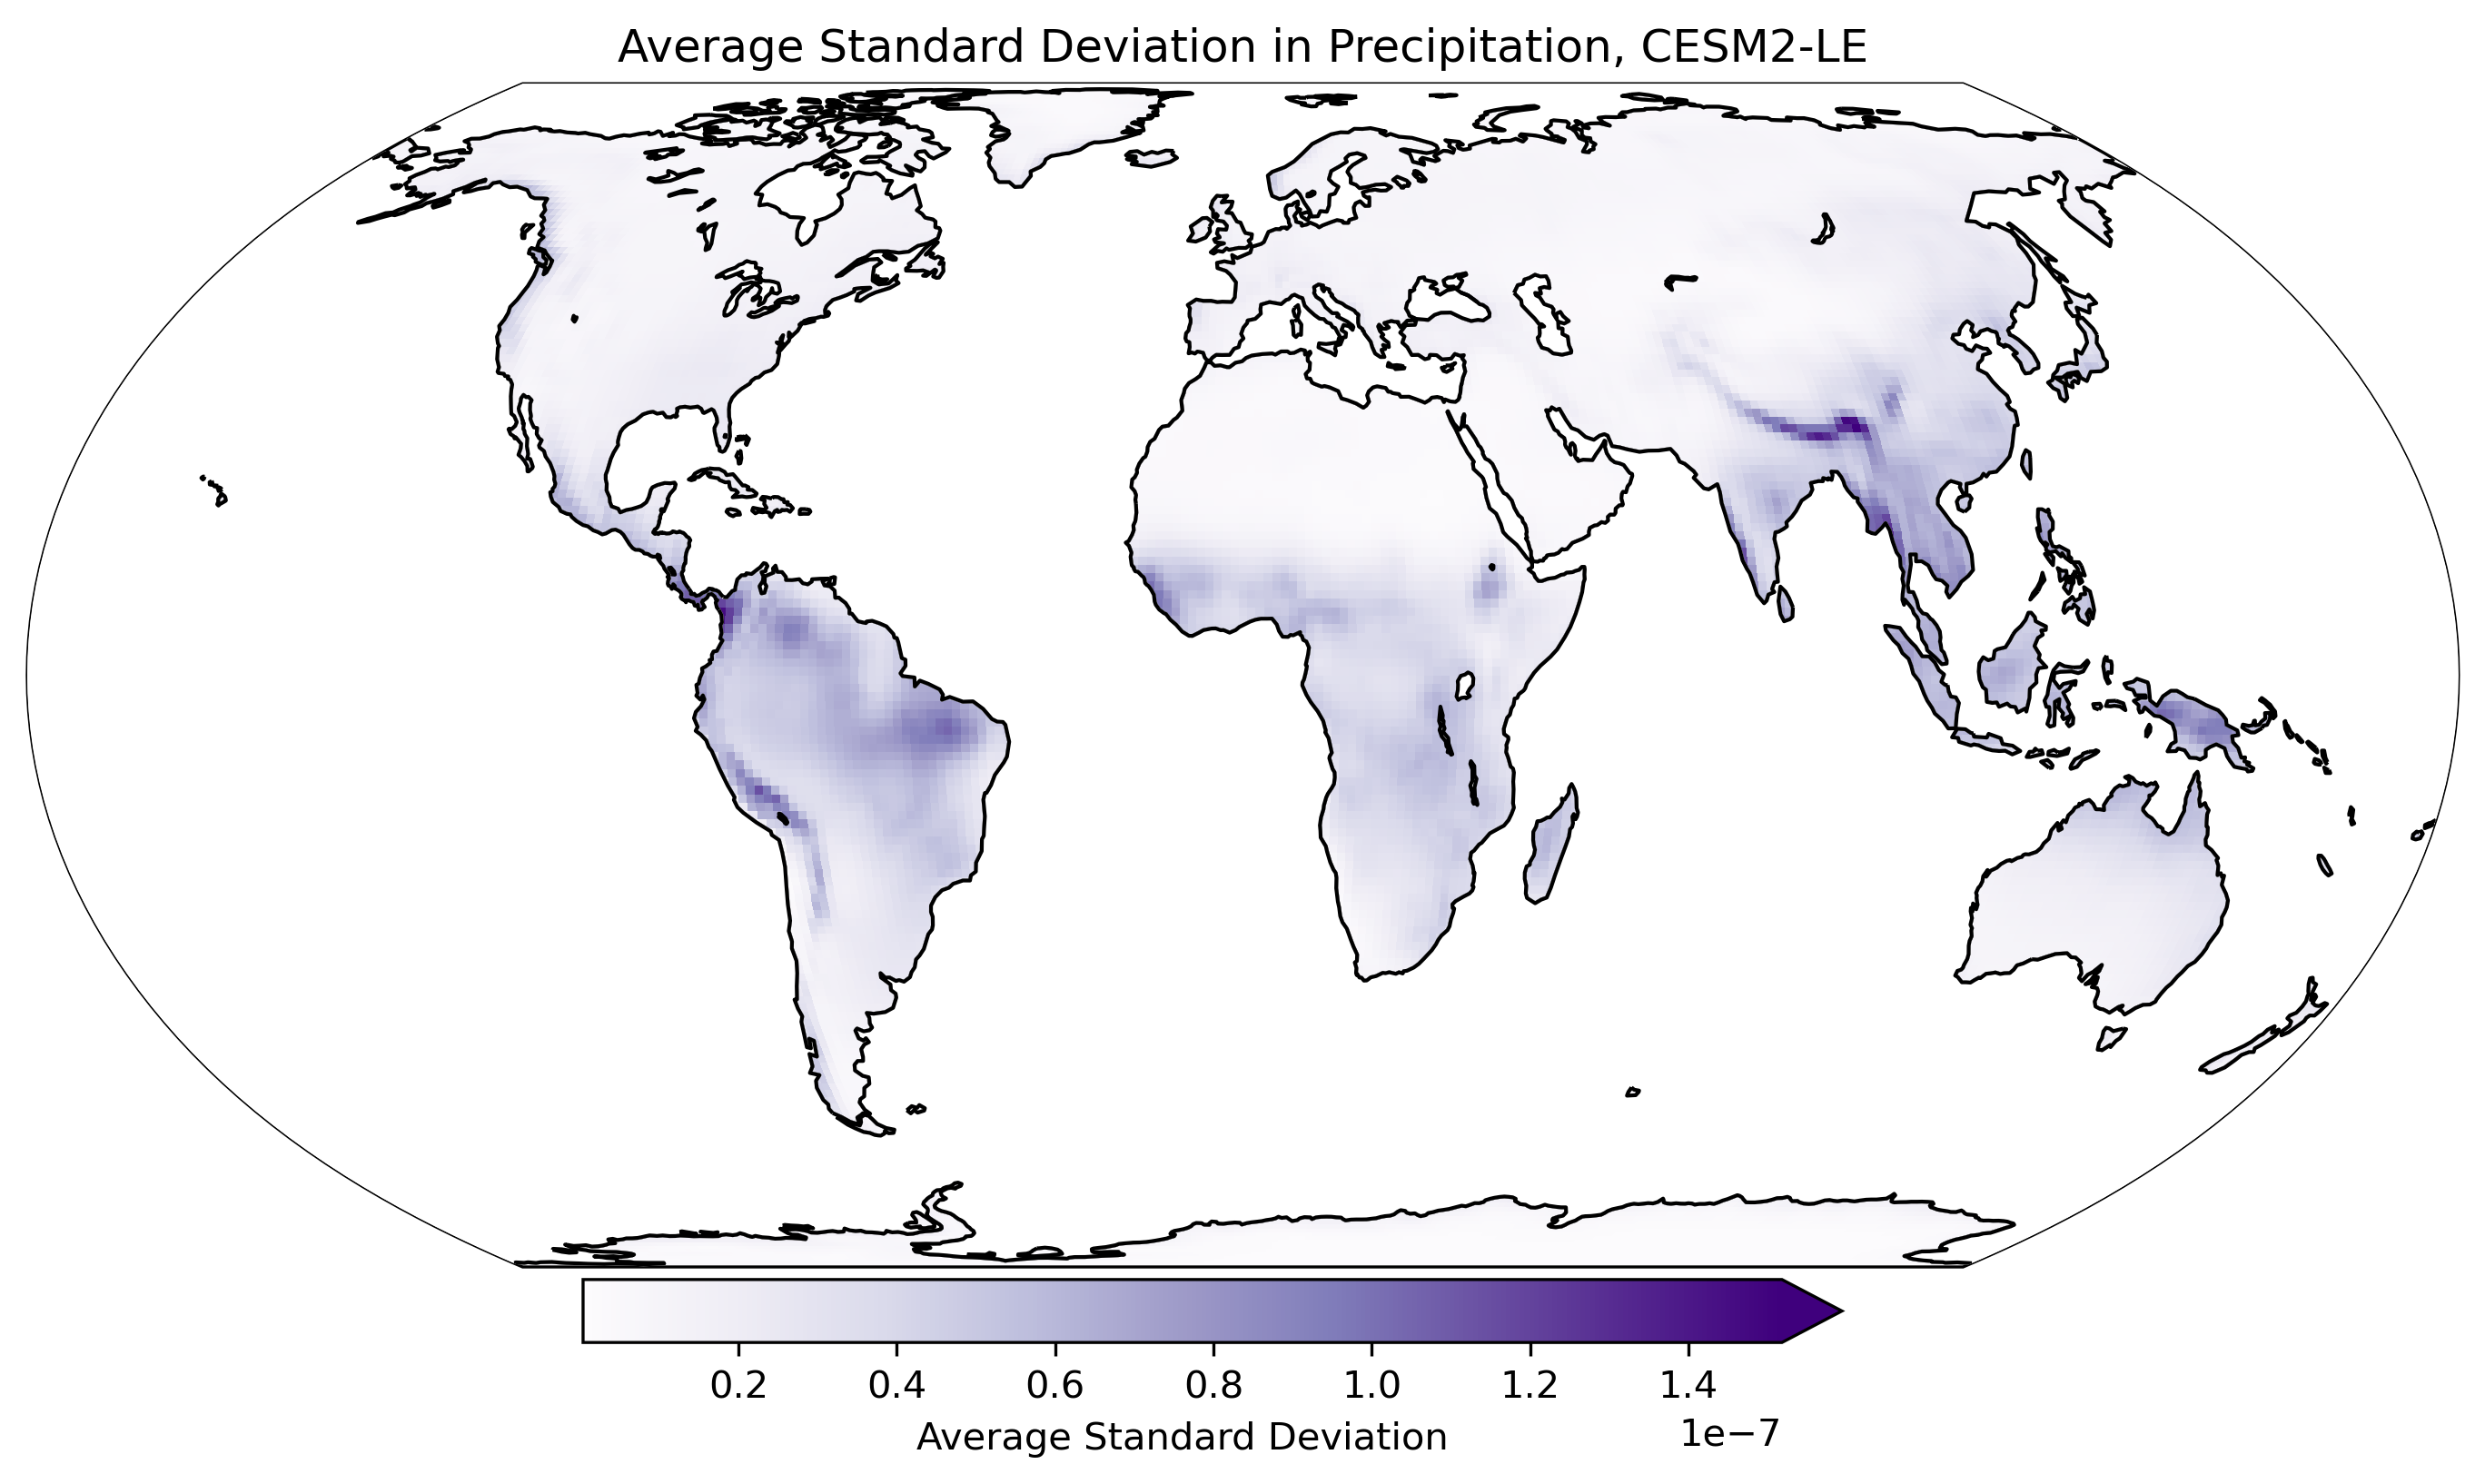

In [31]:
trefht_std = []
for file in sorted_filesnames_prect:
    open_file = xr.load_dataset(file)['PRECT']
    trefht_std.append( np.std(open_file, axis = 0))



avg_std = np.mean(trefht_std, axis = 0)


plt.figure(figsize=(12,6))
ax = plt.axes(projection = ccrs.EqualEarth()) 
plt.pcolormesh(open_file['lon'], open_file['lat'], avg_std, cmap = 'Purples', transform = ccrs.PlateCarree())
plt.colorbar(label = 'Average Standard Deviation', orientation = 'horizontal', extend = 'max', fraction = 0.05, pad = 0.01)
plt.title('Average Standard Deviation in Precipitation, CESM2-LE')
ax.coastlines()
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')


Timeseries of anomalies for visualization purposes 

In [4]:
trefht_data = []
for file in sorted_filenames_trefht:
    open_file = xr.load_dataset(file)["TREFHT"] - 273.15
    var_timespan = open_file - trefht_avg_past
    var_timespan = var_timespan.astype('float16')
    trefht_data.append(var_timespan)

trefht_data_all_membs = xr.concat(trefht_data, dim = 'time')


prect_data = []
for file in sorted_filesnames_prect:
    open_file = xr.load_dataset(file)["PRECT"]
    var_timespan = open_file - prect_avg_past
    var_timespan = var_timespan.astype('float32')
    prect_data.append(var_timespan)

prect_data_all_membs = xr.concat(prect_data, dim = 'time')

month_indices_trefht = trefht_data_all_membs.groupby('time.month')
month_indices_prect = prect_data_all_membs.groupby('time.month')

trefht_quants = [month_indices_trefht[i].quantile(0.90, dim='time') for i in range(1, 13)]
prect_quants = [month_indices_prect[i].quantile(0.10, dim='time') for i in range(1, 13)]

Quantile with external forcing retained.

In [3]:
trefht_data = []
for file in cesm_trefht_files:
    open_file = xr.load_dataset(file)["TREFHT"] - 273.15
    var_timespan = open_file[:612] #- trefht_baseline_temp
    var_timespan = var_timespan.astype('float16')
    trefht_data.append(var_timespan)

trefht_data_all_membs = xr.concat(trefht_data, dim = 'time')


prect_data = []
for file in cesm_prect_files:
    open_file = xr.load_dataset(file)["PRECT"]
    var_timespan = open_file[:612] # - prect_baseline_temp
    var_timespan = var_timespan.astype('float32')
    prect_data.append(var_timespan)

prect_data_all_membs = xr.concat(prect_data, dim = 'time')
#print(prect_data_all_membs)

month_indices_trefht = trefht_data_all_membs.groupby('time.month')
month_indices_prect = prect_data_all_membs.groupby('time.month')

# Compute the quantiles for a specific compound event
trefht_quants = [month_indices_trefht[i].quantile(0.90, dim='time') for i in range(1, 13)]
prect_quants = [month_indices_prect[i].quantile(0.10, dim='time') for i in range(1, 13)]

In [6]:
temp_quants_hold = []
for month in trefht_quants:
    temp_quants_hold.append(month.sel(lat = 40.58, lon = 360 - 105.08, method = 'nearest').values)

precip_quants_hold = []
for month in prect_quants:
    precip_quants_hold.append(month.sel(lat = 40.58, lon = 360 - 105.08, method = 'nearest').values)

Temperature and Precipitation Anomalies for One Location in One Member (527-599 is used for the presentation)

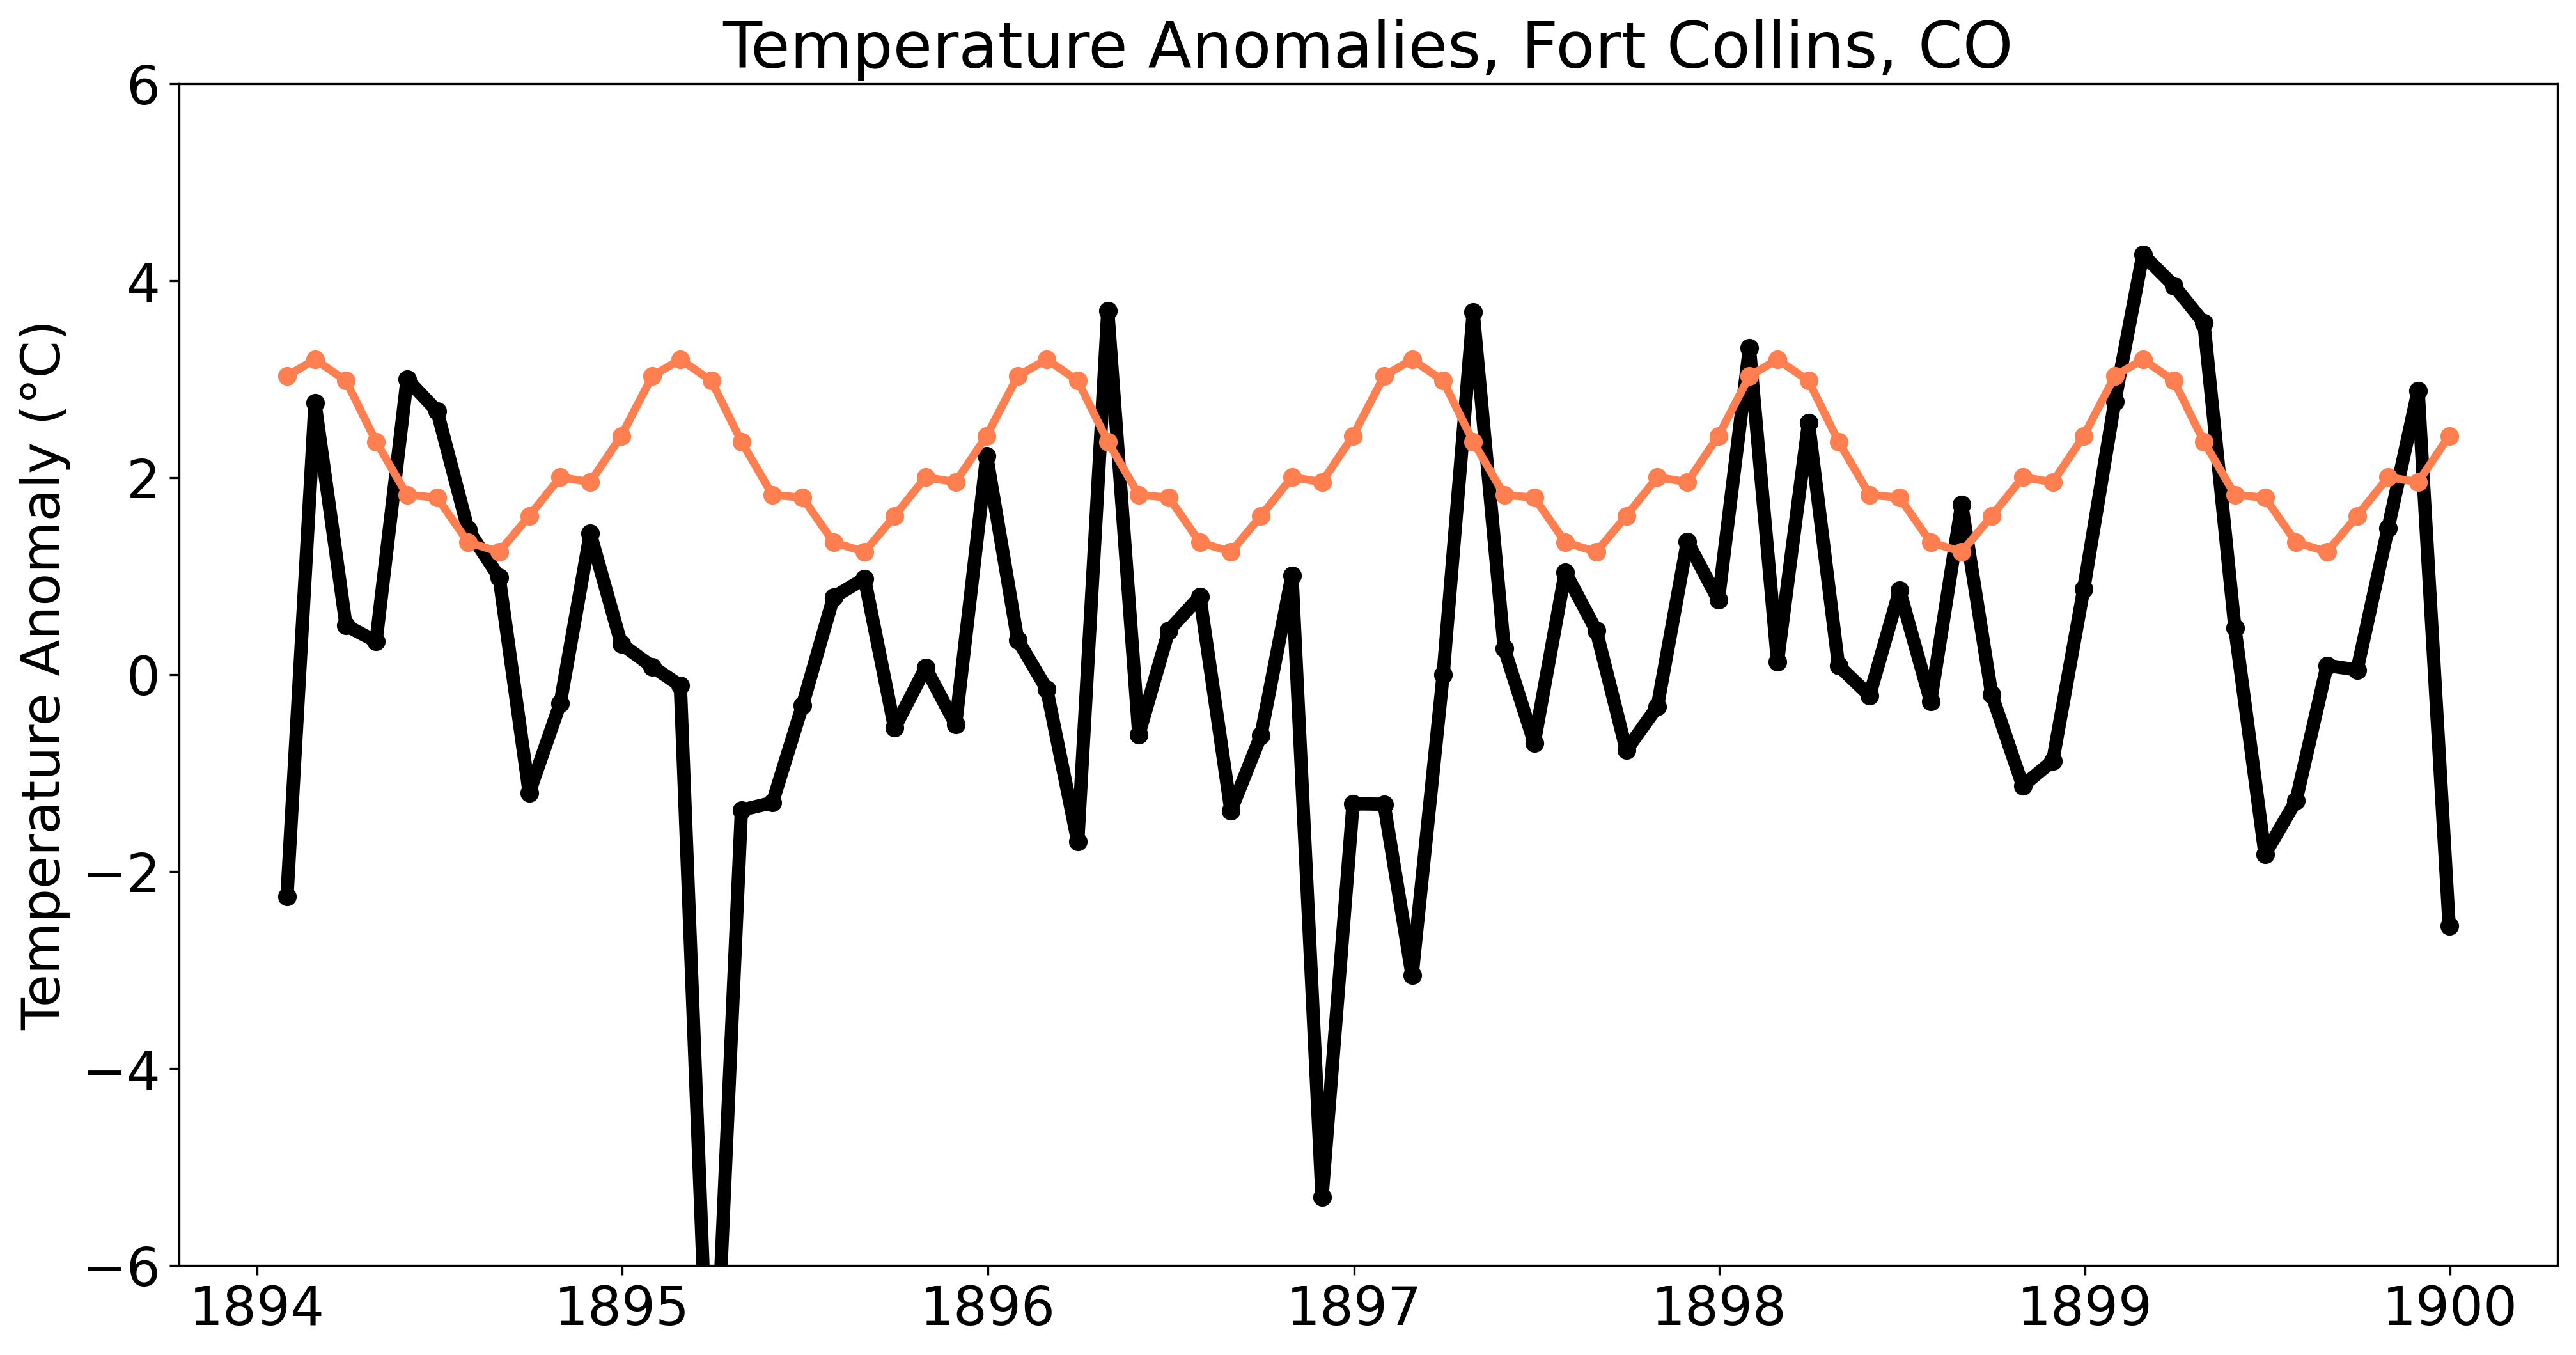

In [24]:
## FOR TEMPERATURE ANOMALIES ##
plt.figure(figsize=(16,8))
dates = pd.date_range(start="1894-01-01", end="1900-01-01", freq="ME")
dates2 = pd.date_range(start="1850-01-01", end = "1951-01-01", freq ="ME")

trefht_anom_clim = xr.load_dataset(cesm_trefht_files[0])["TREFHT"] - 273.15
new_trefht = trefht_anom_clim - trefht_avg_past

quant_ex = (temp_quants_hold * 6)

#plt.axvline(dates[64])
plt.plot(dates, new_trefht[527:599].sel(lat =40.58, lon = 360 - 105.08, method = 'nearest'), color = 'black', linewidth = 5, marker = 'o')
plt.plot(dates, quant_ex, color = 'coral', linewidth = 3, marker = 'o')
#plt.axhspan(quant_ex, max(range(len(dates))), facecolor="red", alpha=0.3, label="Above Threshold")
plt.ylim(-6, 6)
#plt.ylim(-15,30)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.title('Temperature Anomalies, Fort Collins, CO', size = 24)
plt.ylabel('Temperature Anomaly (°C)', size = 20)
plt.show()

# [2508:2580]

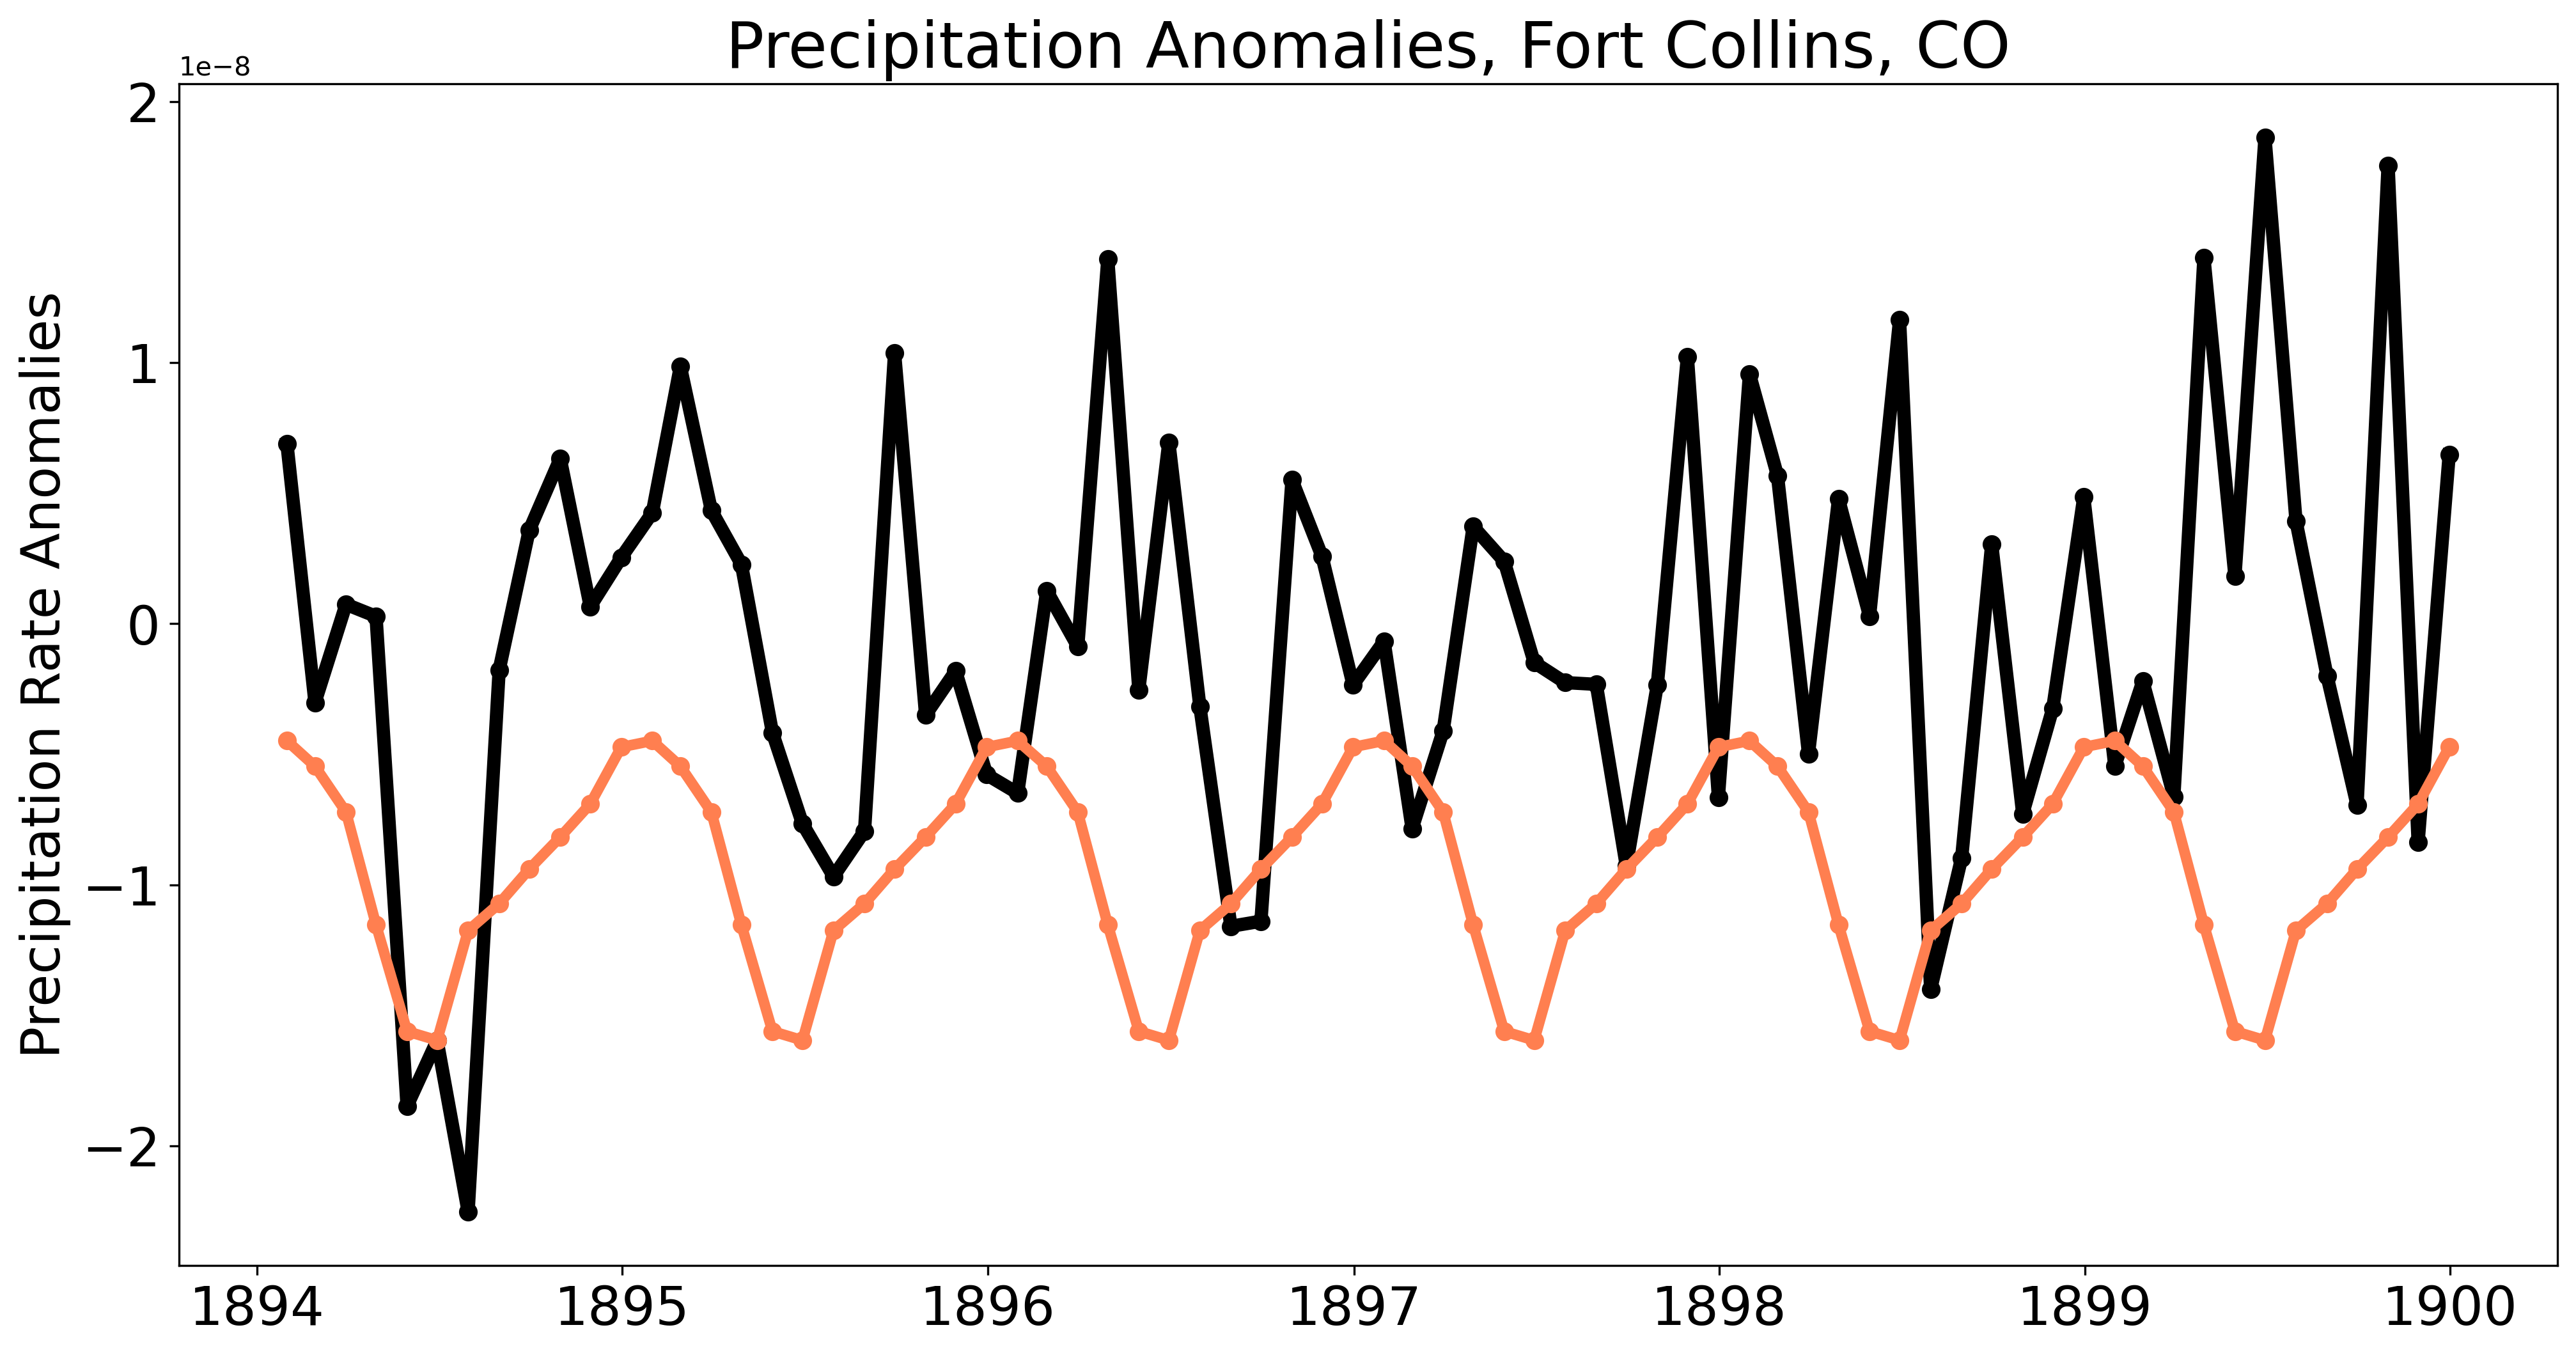

: 

In [31]:
## FOR PRECIP ANOMALIES
plt.figure(figsize=(16,8))
prect_anom_clim = xr.load_dataset(cesm_prect_files[0])["PRECT"]
new_prect = prect_anom_clim - prect_avg_past
#new_prect = new_prect.astype('float32')

quantp_ex = precip_quants_hold * 6

plt.plot(dates, new_prect[527:599].sel(lat = 40.58, lon = 360 - 105.08, method = 'nearest'), color = 'black', linewidth = 5, marker = 'o')
plt.plot(dates, quantp_ex, color = 'coral', linewidth = 4, marker = 'o')
plt.title('Precipitation Anomalies, Fort Collins, CO', size = 24)
#plt.ylim(0,1.2e-7)
plt.ylabel("Precipitation Rate Anomalies", size = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.show()

Visualization of assignment of binary values for compound events at a specific location.

Text(0, 0.5, 'Compound Event')

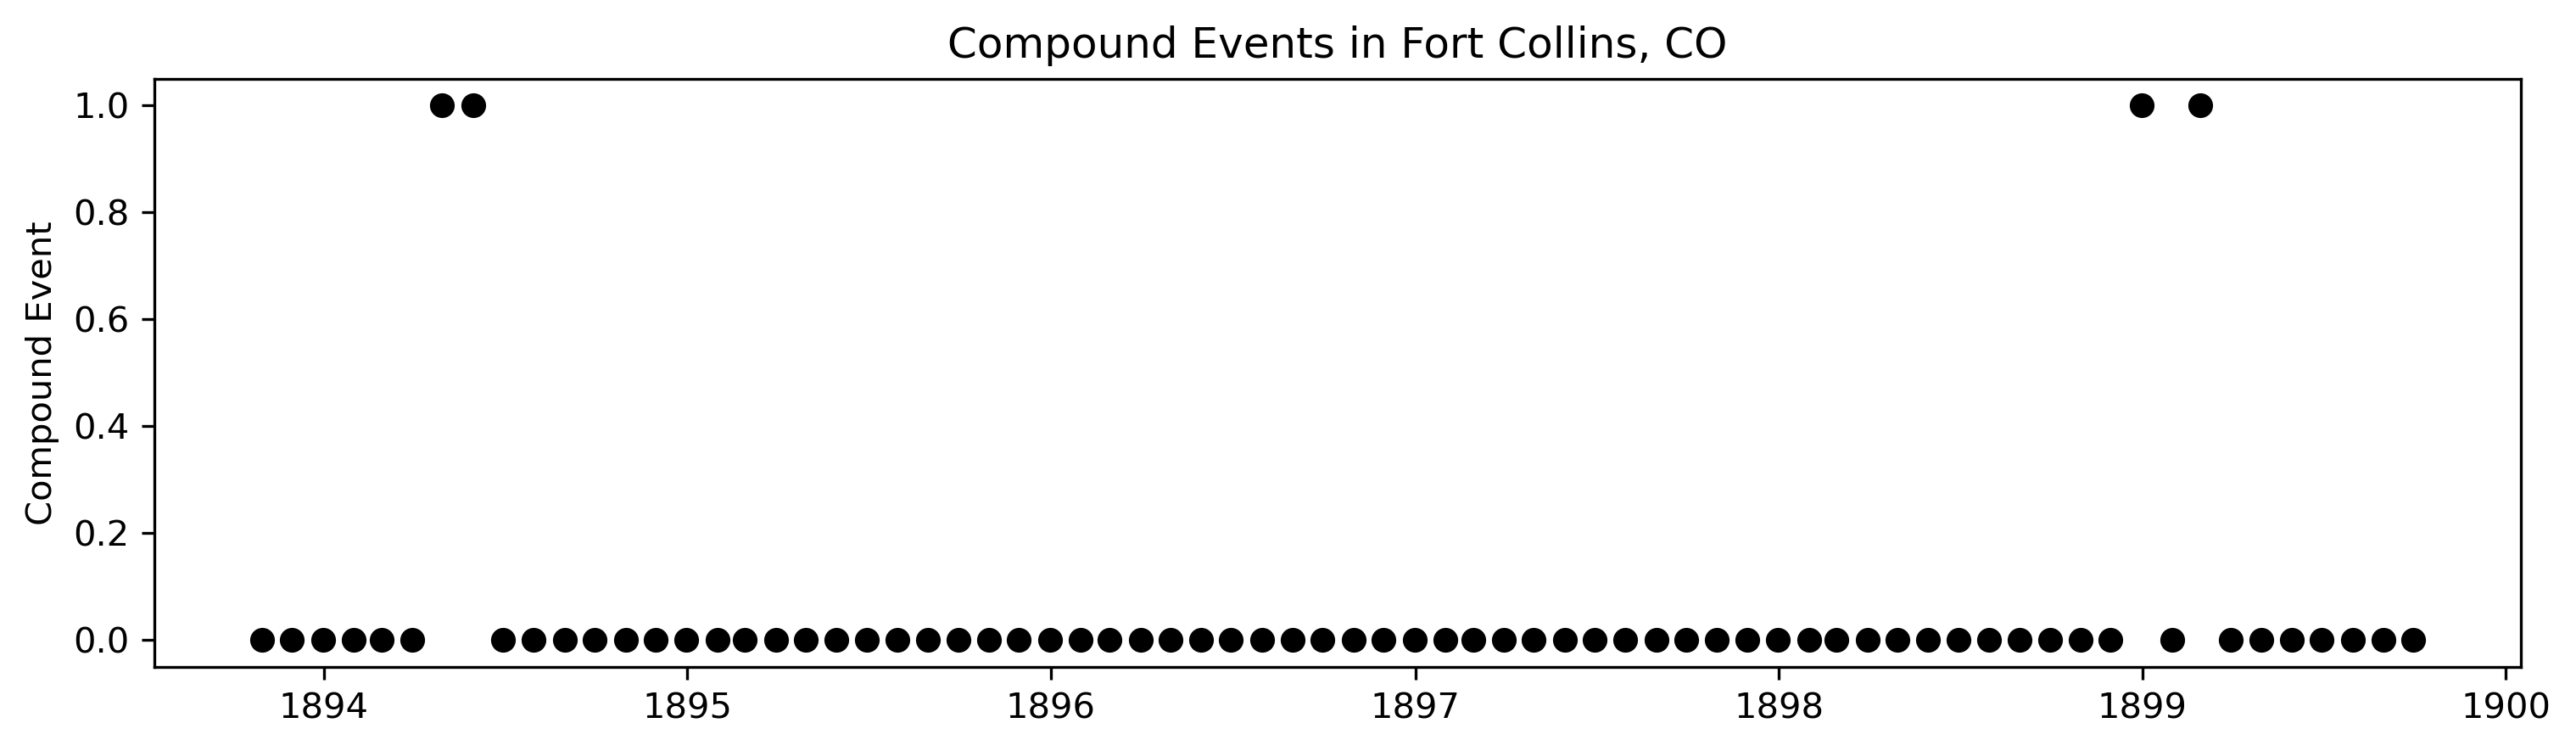

In [76]:
plt.figure(figsize = (12,3))
plt.scatter(dates, CES_all_locations_binary_past[0][525:597].sel(lat =40.58, lon = 360 - 105.08, method = 'nearest'), color = 'black')
plt.title("Compound Events in Fort Collins, CO")
plt.ylabel("Compound Event")


Process Bootstrapping Code

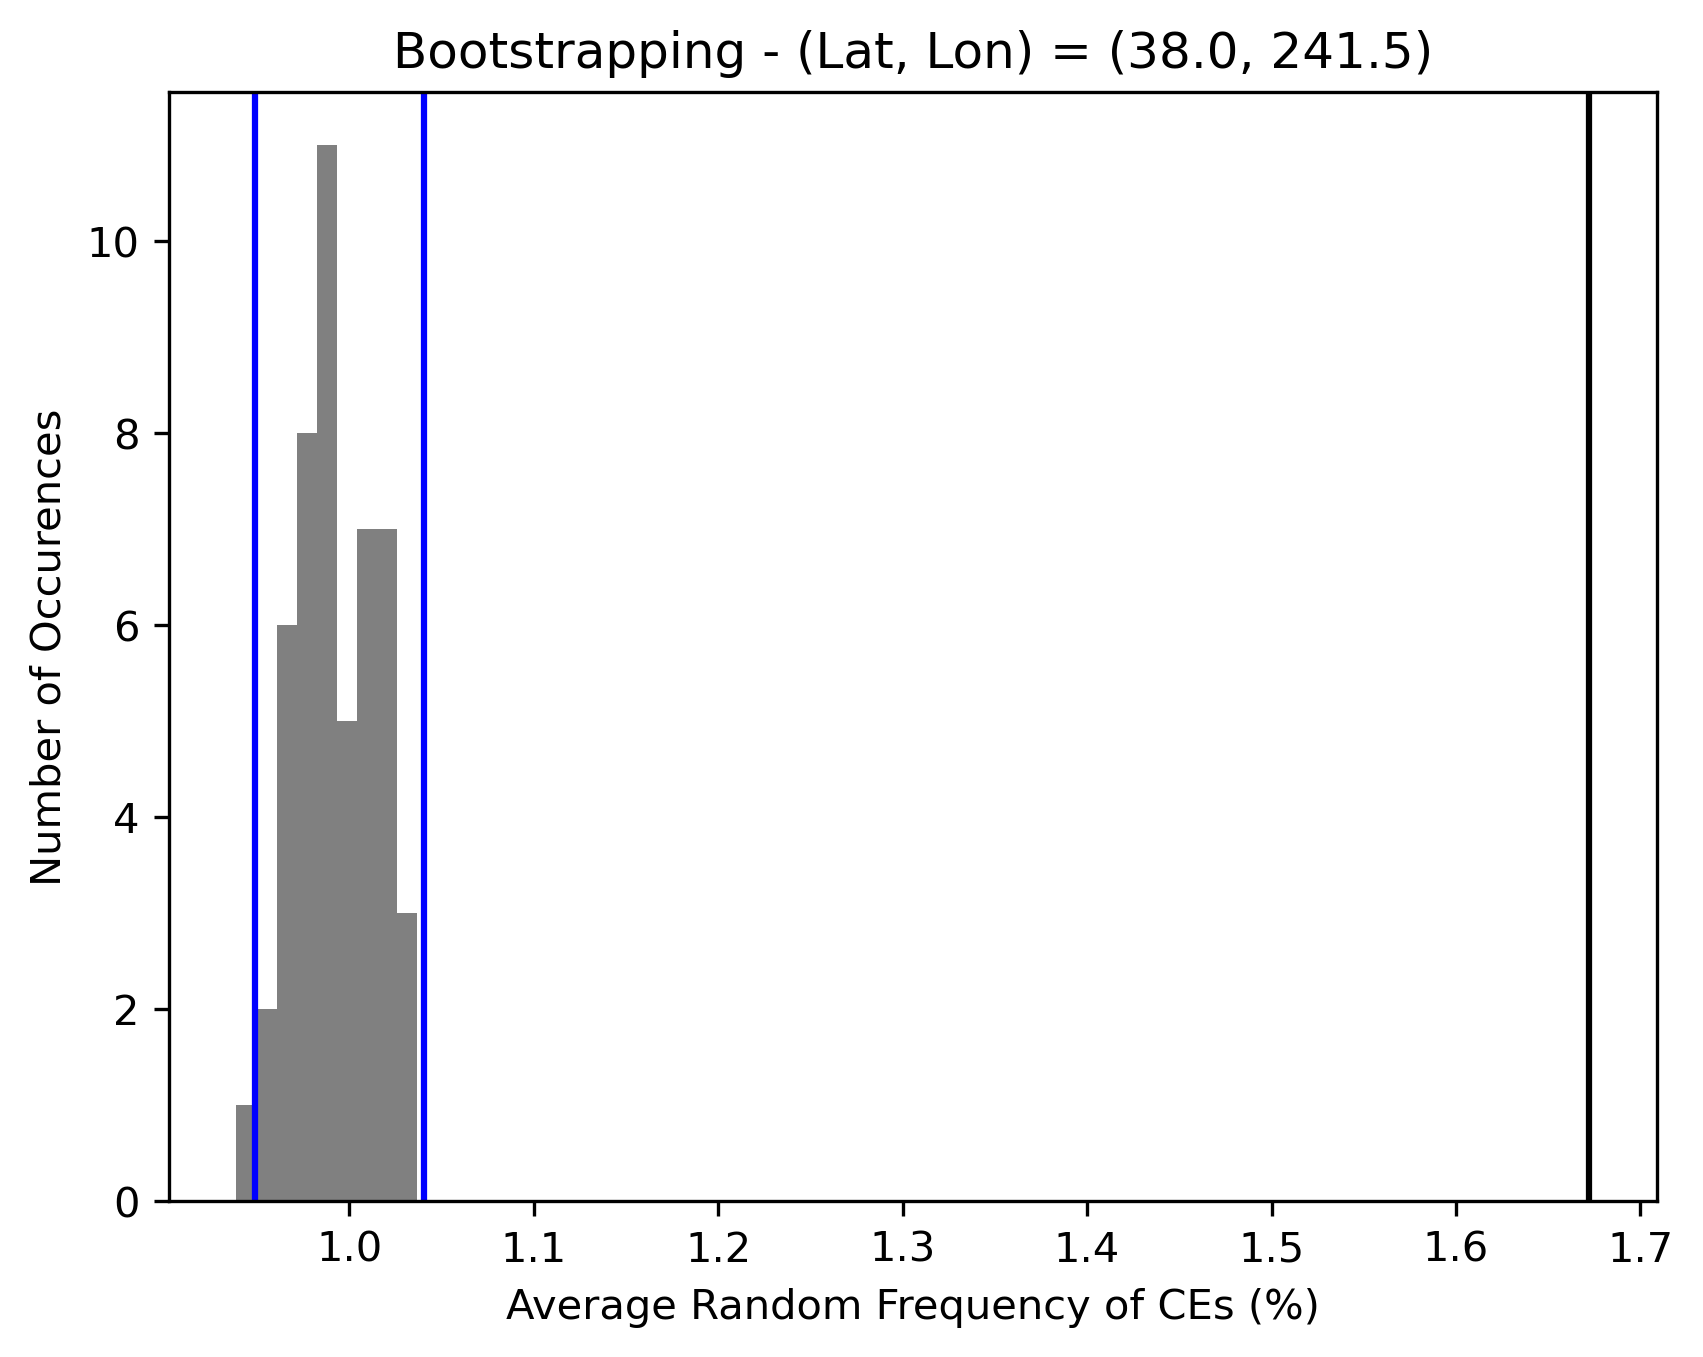

In [33]:
bootstrap_first_half = xr.open_dataarray('/Users/aedwyer/Documents/CESM_data/boostrapping_0_50scrambles_90T_10PQuantilesPerMonth18502000.nc')
bootstrap_second_half = xr.open_dataarray('/Users/aedwyer/Documents/CESM_data/boostrapping_50_99scrambles_90T_10PQuantilesPerMonth18502000.nc')

bootstrap_total = xr.concat([bootstrap_first_half * 100, bootstrap_second_half* 100], dim = 'time')

bootstrap_lower_bound = bootstrap_total.quantile(0.01, dim = 'time')
bootstrap_upper_bound = bootstrap_total.quantile(0.99, dim = 'time')

# Choose the location you want
lat_choice = 38.00
lon_choice = 360-118.50
# compound event bootstrap histogram for a single location
bootstrap_histogram_plot(lat_choice, lon_choice, bootstrap_first_half * 100, bootstrap_upper_bound, bootstrap_lower_bound, f"Bootstrapping - (Lat, Lon) = ({lat_choice}, {np.round(lon_choice, 2)})" )
plt.axvline(1.67222222, color = 'black')
plt.show()

Computing Compound Events, don't need to run unless you are remaking one of the files already saved, CODE MOVED IN FROM ASHA 11/11/24, should be making the same frequencies as the asha code now and the files that are already read in.

In [16]:
## QUANTILE CALCULATION ##
## POOL MEMBERS TOGETHER ##
trefht_data = []
for file in sorted_filenames_trefht:
    open_file = xr.load_dataset(file)["TREFHT"] - 273.15
    var_timespan = open_file - trefht_avg_past
    var_timespan = var_timespan.astype('float16')
    trefht_data.append(var_timespan)

trefht_data_all_membs = xr.concat(trefht_data, dim = 'time')


prect_data = []
for file in sorted_filesnames_prect:
    open_file = xr.load_dataset(file)["PRECT"]
    var_timespan = open_file - prect_avg_past
    var_timespan = var_timespan.astype('float32')
    prect_data.append(var_timespan)

prect_data_all_membs = xr.concat(prect_data, dim = 'time')

month_indices_trefht = trefht_data_all_membs.groupby('time.month')
month_indices_prect = prect_data_all_membs.groupby('time.month')

trefht_quants = [month_indices_trefht[i].quantile(0.90, dim='time') for i in range(1, 13)]
prect_quants = [month_indices_prect[i].quantile(0.10, dim='time') for i in range(1, 13)]

## CE CALCULATION ## 
sum_freq = 0
total_length_timeseries = 0
member_i = 1
CES_all_locations_binary = []

for file_it, file in enumerate(sorted_filenames_trefht):
    print(file)
    print(sorted_filesnames_prect[file_it])
    trefht_anom_clim = xr.load_dataset(file)["TREFHT"] - 273.15
    trefht_anom_clim = trefht_anom_clim - trefht_avg_past

    month_indices_trefht = trefht_anom_clim.groupby('time.month')

    prect_anom_clim = xr.load_dataset(sorted_filesnames_prect[file_it])["PRECT"]
    prect_anom_clim = prect_anom_clim - prect_avg_past

    month_indices_prect = prect_anom_clim.groupby('time.month')

    ce_binary = xr.zeros_like(trefht_anom_clim)
    
    for i in range(1, 13):
        trefht_month = month_indices_trefht.groups[i]
        prect_month = month_indices_prect.groups[i]
        ce_binary[trefht_month] = ((trefht_anom_clim[trefht_month] >= trefht_quants[i-1]) & 
                                    (prect_anom_clim[prect_month] <= prect_quants[i-1])) * 1
        
    CES_all_locations_binary.append(ce_binary)

    # add the frequency to the sum
    sum_freq += (ce_binary == 1).sum(axis = 0)
    total_length_timeseries += len(ce_binary)
    member_i += 1

pooled_frequency = (sum_freq / total_length_timeseries) * 100

NameError: name 'trefht_avg' is not defined

Create a file for the quantiles per month binary with the sorted files

In [7]:
# Create a list to hold DataArrays with the member coordinate added
data_arrays_with_member = []

for i, data_array in enumerate(CES_all_locations_binary):
    # Add the member coordinate
    data_array = data_array.assign_coords(member=i)
    data_arrays_with_member.append(data_array)
    
# Concatenate the DataArrays along a new dimension (e.g., 'member')
concatenated_data = xr.concat(data_arrays_with_member, dim='member')
concatenated_data.to_netcdf('QuantilesPerMonth_90T_10P_2050_2100_SortedFiles.nc')

sum all of the frequencies from the pre-saved file in order to take an average, and then plot the average, not pooled

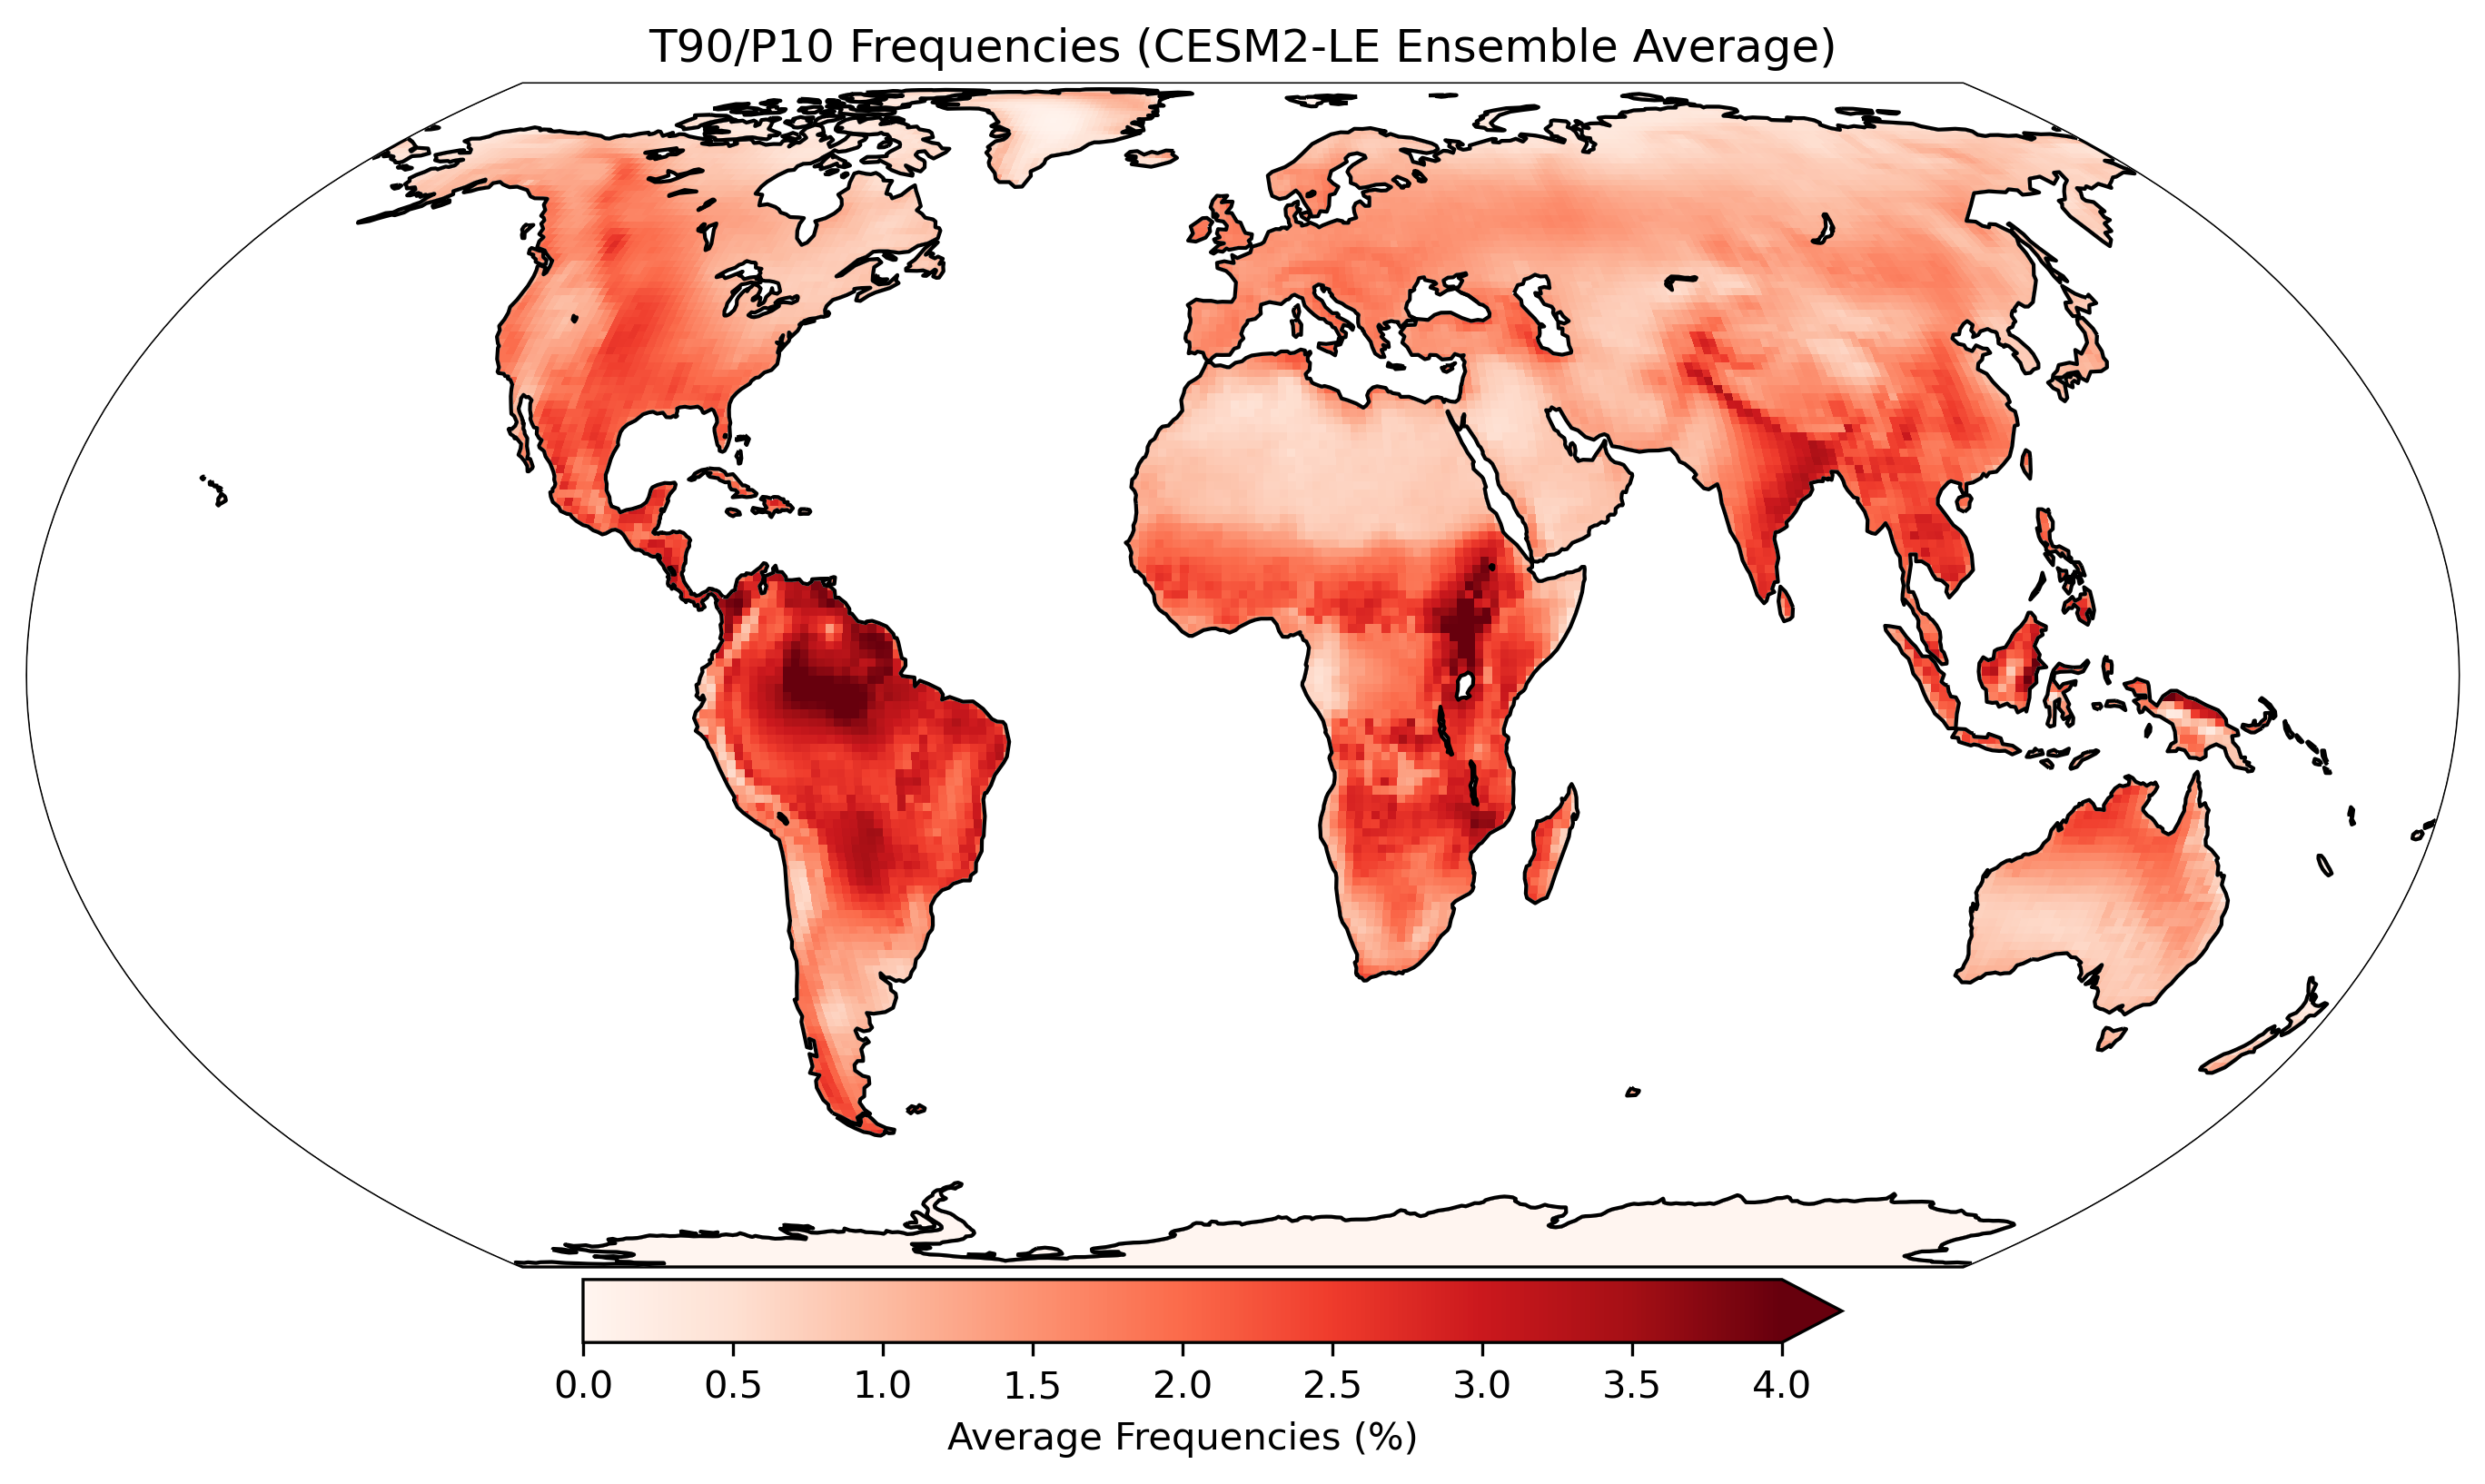

In [3]:
sum_freq = 0
for mem in ces_qpm_sorted_past['member']:
    mem_select = ces_qpm_sorted_past.sel(member = mem)
    sum_freq += (mem_select['TREFHT'] == 1).sum(axis = 0) / len(mem_select['TREFHT'])

average_over_all_members = (sum_freq / 100) * 100

lat = average_over_all_members['lat']
lon = average_over_all_members['lon']

lat_threshold = -57

mask = average_over_all_members['lat'] >= lat_threshold
masked_lat = average_over_all_members['lat'][mask]
masked_data = average_over_all_members.isel(lat = mask)

plt.figure(figsize=(12,6))
ax = plt.axes(projection = ccrs.EqualEarth()) 
plt.pcolormesh(masked_data['lon'], masked_lat, masked_data, cmap = 'Reds', transform = ccrs.PlateCarree(), vmin = 0, vmax = 4)
plt.colorbar(label = 'Average Frequencies (%)', orientation = 'horizontal', extend = 'max', fraction = 0.05, pad = 0.01)
ax.coastlines()
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='white')

plt.title('T90/P10 Frequencies (CESM2-LE Ensemble Average)')

## To plot certain locations ## 
#plt.plot(360-60, -2.85, transform = ccrs.PlateCarree(), marker = 's', color = 'white', zorder = 101, markersize = 8, markerfacecolor = 'none') # Brazil '#4DE061'
#plt.plot(32.50, 5, transform = ccrs.PlateCarree(), marker = 's', color = 'white', zorder = 101, markersize = 8, markerfacecolor = 'none') # South Sudan
#plt.plot(87.80, 23.64, transform = ccrs.PlateCarree(), marker = 's', color = '#4A47ED', zorder = 101, markersize = 6, markerfacecolor = 'none') # India
#plt.plot(116.02, -0.54, transform = ccrs.PlateCarree(), marker = 's', color = '#96CBFF', zorder = 101, markersize = 6, markerfacecolor = 'none') # Indonesia
#plt.plot(360-117.02, 37.68, transform = ccrs.PlateCarree(), marker = 's', color = '#DBF227', zorder = 101, markersize = 6, markerfacecolor = 'none') # Nevada

plt.show()




Computing Variances NOT POOLED QUANTILE

In [36]:
variances_list = []

for file_it, file in enumerate(cesm_trefht_files):
    ce_list = []
    trefht_anom_clim = xr.load_dataset(file)["TREFHT"] - 273.15
    trefht_anom_clim = trefht_anom_clim - trefht_avg_past

    month_indices_trefht = trefht_anom_clim.groupby('time.month')

    prect_anom_clim = xr.load_dataset(cesm_prect_files[file_it])["PRECT"]
    prect_anom_clim = prect_anom_clim - prect_avg_past
    print(file)
    print(cesm_prect_files[file_it])
    month_indices_prect = prect_anom_clim.groupby('time.month')

    # Find Quantiles
    trefht_quants = [month_indices_trefht[i].quantile(0.90, dim='time') for i in range(1, 13)]
    prect_quants = [month_indices_prect[i].quantile(0.10, dim='time') for i in range(1, 13)]

    ce_binary = xr.zeros_like(trefht_anom_clim)
    
    for i in range(1, 13):
        trefht_month = month_indices_trefht.groups[i]
        prect_month = month_indices_prect.groups[i]
        ce_binary[trefht_month] = ((trefht_anom_clim[trefht_month] >= trefht_quants[i-1]) & 
                                    (prect_anom_clim[prect_month] <= prect_quants[i-1])) * 1
        
    i = 0
    while i <= len(ce_binary['time']) - 120:
        ce_list.append(((ce_binary[i:i + 120] == 1).sum(dim='time')))
        i += 12
    #CES_mean.append(np.mean(ce_list, axis = 0))
    variance = np.var(ce_list, axis = 0)
    variances_list.append(xr.DataArray(variance, coords = {'latitude': ce_binary['lat'], 'longitude': ce_binary['lon']}, dims = ['lat', 'lon']))

    print(file_it)

../CESM_data/TREFHT/2mtemptaketwo/CMIP6.LE2-1001.001.TREFHT.1850-2100.shifted.nc
../CESM_data/PRECT/prect_data_take_two/CMIP6.LE2-1001.001.PRECT.1850-2100.shifted.nc
0
../CESM_data/TREFHT/2mtemptaketwo/CMIP6.LE2-1021.002.TREFHT.1850-2100.shifted.nc
../CESM_data/PRECT/prect_data_take_two/CMIP6.LE2-1021.002.PRECT.1850-2100.shifted.nc
1
../CESM_data/TREFHT/2mtemptaketwo/CMIP6.LE2-1041.003.TREFHT.1850-2100.shifted.nc
../CESM_data/PRECT/prect_data_take_two/CMIP6.LE2-1041.003.PRECT.1850-2100.shifted.nc
2
../CESM_data/TREFHT/2mtemptaketwo/CMIP6.LE2-1061.004.TREFHT.1850-2100.shifted.nc
../CESM_data/PRECT/prect_data_take_two/CMIP6.LE2-1061.004.PRECT.1850-2100.shifted.nc
3
../CESM_data/TREFHT/2mtemptaketwo/CMIP6.LE2-1081.005.TREFHT.1850-2100.shifted.nc
../CESM_data/PRECT/prect_data_take_two/CMIP6.LE2-1081.005.PRECT.1850-2100.shifted.nc
4
../CESM_data/TREFHT/2mtemptaketwo/CMIP6.LE2-1101.006.TREFHT.1850-2100.shifted.nc
../CESM_data/PRECT/prect_data_take_two/CMIP6.LE2-1101.006.PRECT.1850-2100.shift

In [6]:
variances_list_future = []

for file_it, file in enumerate(cesm_trefht_files):
    ce_list = []
    trefht_anom_clim = xr.load_dataset(file)["TREFHT"] - 273.15
    trefht_anom_clim = trefht_anom_clim - trefht_avg_future

    month_indices_trefht = trefht_anom_clim.groupby('time.month')

    prect_anom_clim = xr.load_dataset(cesm_prect_files[file_it])["PRECT"]
    prect_anom_clim = prect_anom_clim - prect_avg_future

    month_indices_prect = prect_anom_clim.groupby('time.month')

    # Find Quantiles
    trefht_quants = [month_indices_trefht[i].quantile(0.90, dim='time') for i in range(1, 13)]
    prect_quants = [month_indices_prect[i].quantile(0.10, dim='time') for i in range(1, 13)]

    ce_binary = xr.zeros_like(trefht_anom_clim)
    
    for i in range(1, 13):
        trefht_month = month_indices_trefht.groups[i]
        prect_month = month_indices_prect.groups[i]
        ce_binary[trefht_month] = ((trefht_anom_clim[trefht_month] >= trefht_quants[i-1]) & 
                                    (prect_anom_clim[prect_month] <= prect_quants[i-1])) * 1
        
    i = 0
    while i <= len(ce_binary['time']) - 120:
        ce_list.append(((ce_binary[i:i + 120] == 1).sum(dim='time')))
        i += 12
    #CES_mean.append(np.mean(ce_list, axis = 0))
    variance = np.var(ce_list, axis = 0)
    variances_list_future.append(xr.DataArray(variance, coords = {'latitude': ce_binary['lat'], 'longitude': ce_binary['lon']}, dims = ['lat', 'lon']))

    print(file_it)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [10]:
variance_difference_list = []
for i, i_list in enumerate(variances_list):
    variance_difference_list.append(variances_list_future[i] - i_list)

Plot Variances

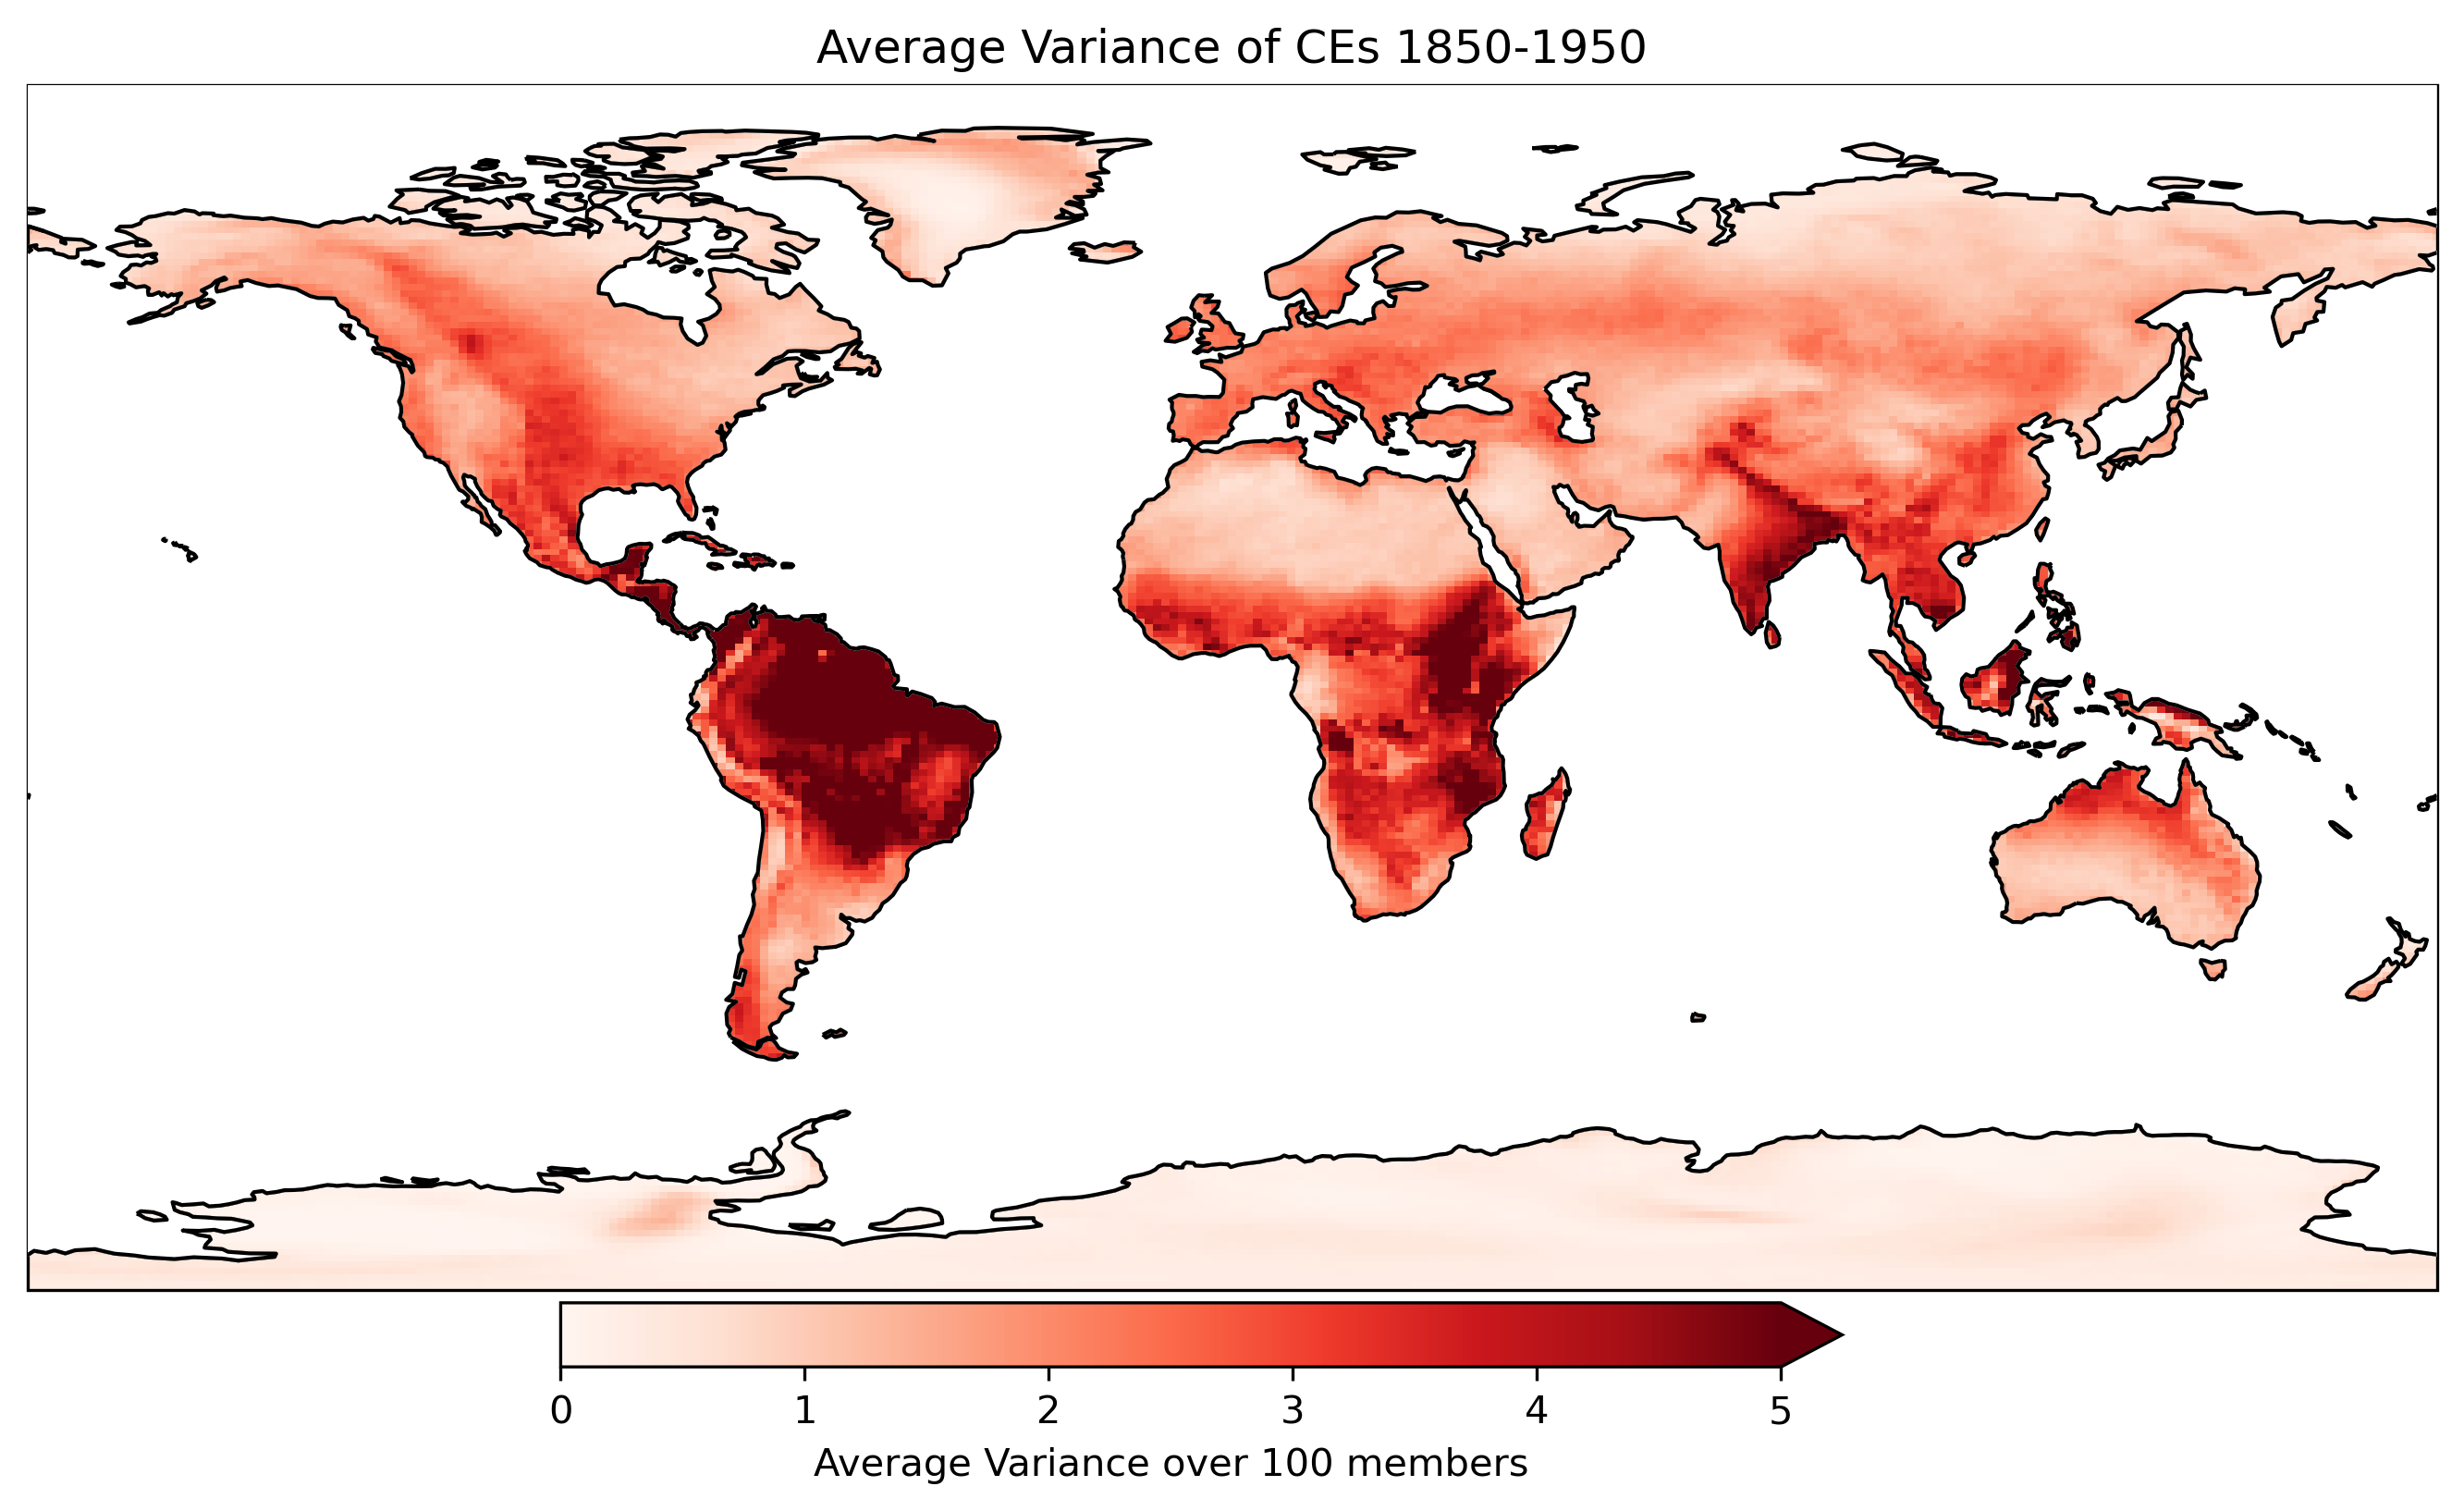

In [42]:
lat = np.round(ce_binary['lat'], 6)
lon = np.round(ce_binary['lon'], 6)
variances_global = xr.DataArray(np.mean(variances_list, axis = 0), coords = {'latitude': lat, 'longitude': lon}, dims = ['lat', 'lon'])
variances_global_aligned = variances_global.assign_coords(latitude=ce_binary['lat'], longitude=ce_binary['lon'])


plt.figure(figsize=(12,6))
ax = plt.axes(projection = ccrs.PlateCarree()) 
plt.pcolormesh(lon, lat, variances_global_aligned, cmap = 'Reds', transform = ccrs.PlateCarree(), vmin = 0, vmax =5)
cbar = plt.colorbar(label = 'Average Variance over 100 members', extend = 'max', orientation = 'horizontal', fraction = 0.05, pad = 0.01)
ax.coastlines()
ax.add_feature(cart.feature.OCEAN, zorder = 100, edgecolor='k', color = 'white')
ax.add_feature(cfeature.COASTLINE, zorder = 101, edgecolor = 'black')
plt.title(f"Average Variance of CEs 1850-1950")

#plt.plot(360-52.52, -2.85, transform = ccrs.PlateCarree(), marker = 's', color = '#59FFF9', zorder = 101, markersize = 6, markerfacecolor = 'none') # Brazil '#4DE061'
#plt.plot(31.36, 4.48, transform = ccrs.PlateCarree(), marker = 's', color = '#A547ED', zorder = 101, markersize = 6, markerfacecolor = 'none') # South Sudan
#plt.plot(87.80, 23.64, transform = ccrs.PlateCarree(), marker = 's', color = '#4A47ED', zorder = 101, markersize = 6, markerfacecolor = 'none') # India
#plt.plot(116.02, -0.54, transform = ccrs.PlateCarree(), marker = 's', color = '#96CBFF', zorder = 101, markersize = 6, markerfacecolor = 'none') # Indonesia
#plt.plot(360-117.02, 37.68, transform = ccrs.PlateCarree(), marker = 's', color = '#DBF227', zorder = 101, markersize = 6, markerfacecolor = 'none') # Nevada

plt.show()

Text(0.5, 1.0, 'Variance Distributions for Different Locations - 1850-2000, Quantiles per month')

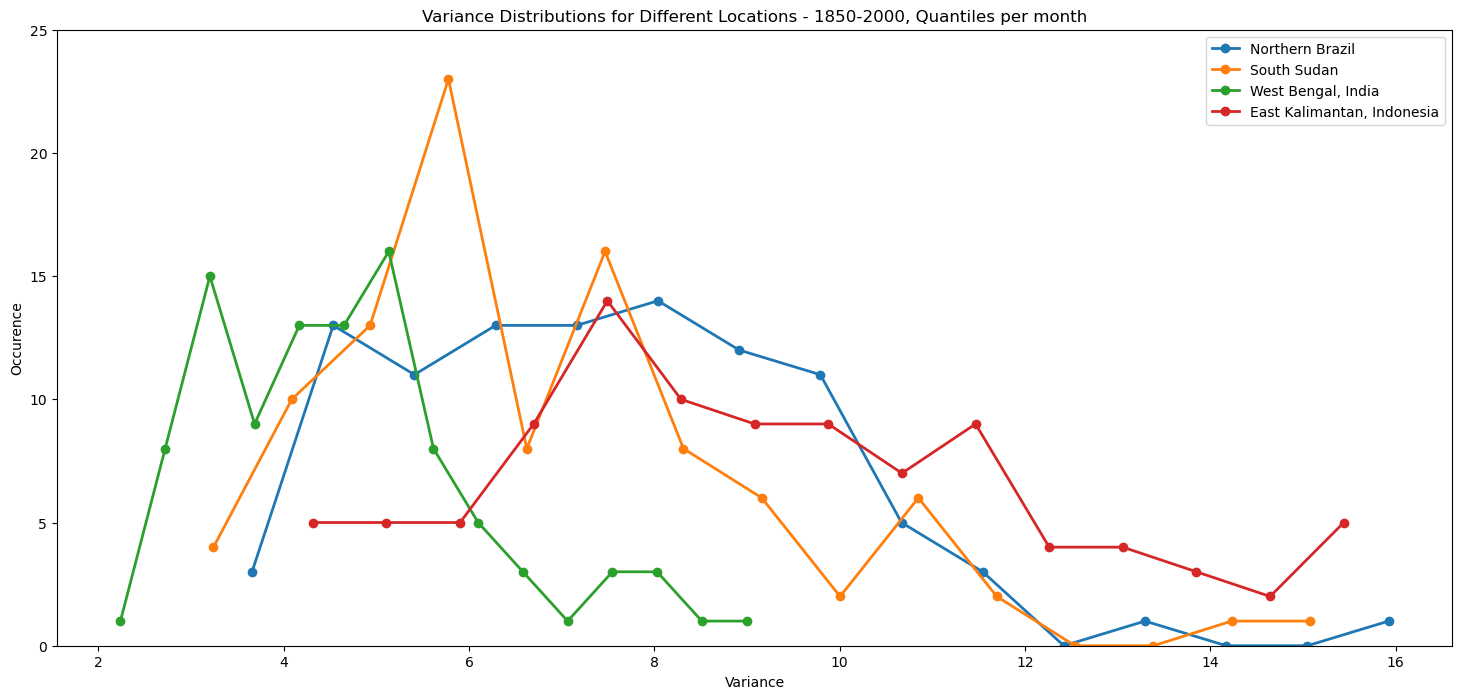

In [26]:
locations = [(-2.85, 360-52.52), (4.48, 31.36), (23.64, 87.80), (-0.54, 116.02)]
all_locations_vars = []
for lat_c, lon_c in locations:
    test_list = []
    for mem in variances_list:
        mem = mem.assign_coords(latitude=ce_binary['lat'], longitude=ce_binary['lon'])
        test_list.append(mem.sel(lat = lat_c, lon = lon_c, method = 'nearest'))
    all_locations_vars.append(test_list)

pdfs = []
location_names = ['Northern Brazil', 'South Sudan', 'West Bengal, India', 'East Kalimantan, Indonesia']
for loc in all_locations_vars:
    # Calculate the PDF from the histogram
    hist, edges = np.histogram(loc, bins=15)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    pdfs.append((bin_centers, hist))

plt.figure(figsize = (18, 8))
for i, (x_values, loc_pdf) in enumerate(pdfs[0:6]):
    plt.plot(x_values, loc_pdf, linewidth=2, label = location_names[i], marker = 'o')

plt.legend()
plt.ylim(0,25)
plt.xlabel('Variance')
plt.ylabel('Occurence')
plt.title('Variance Distributions for Different Locations - 1850-2000, Quantiles per month')

Surface Temperature Composite Maps (used for paper figures)

1328


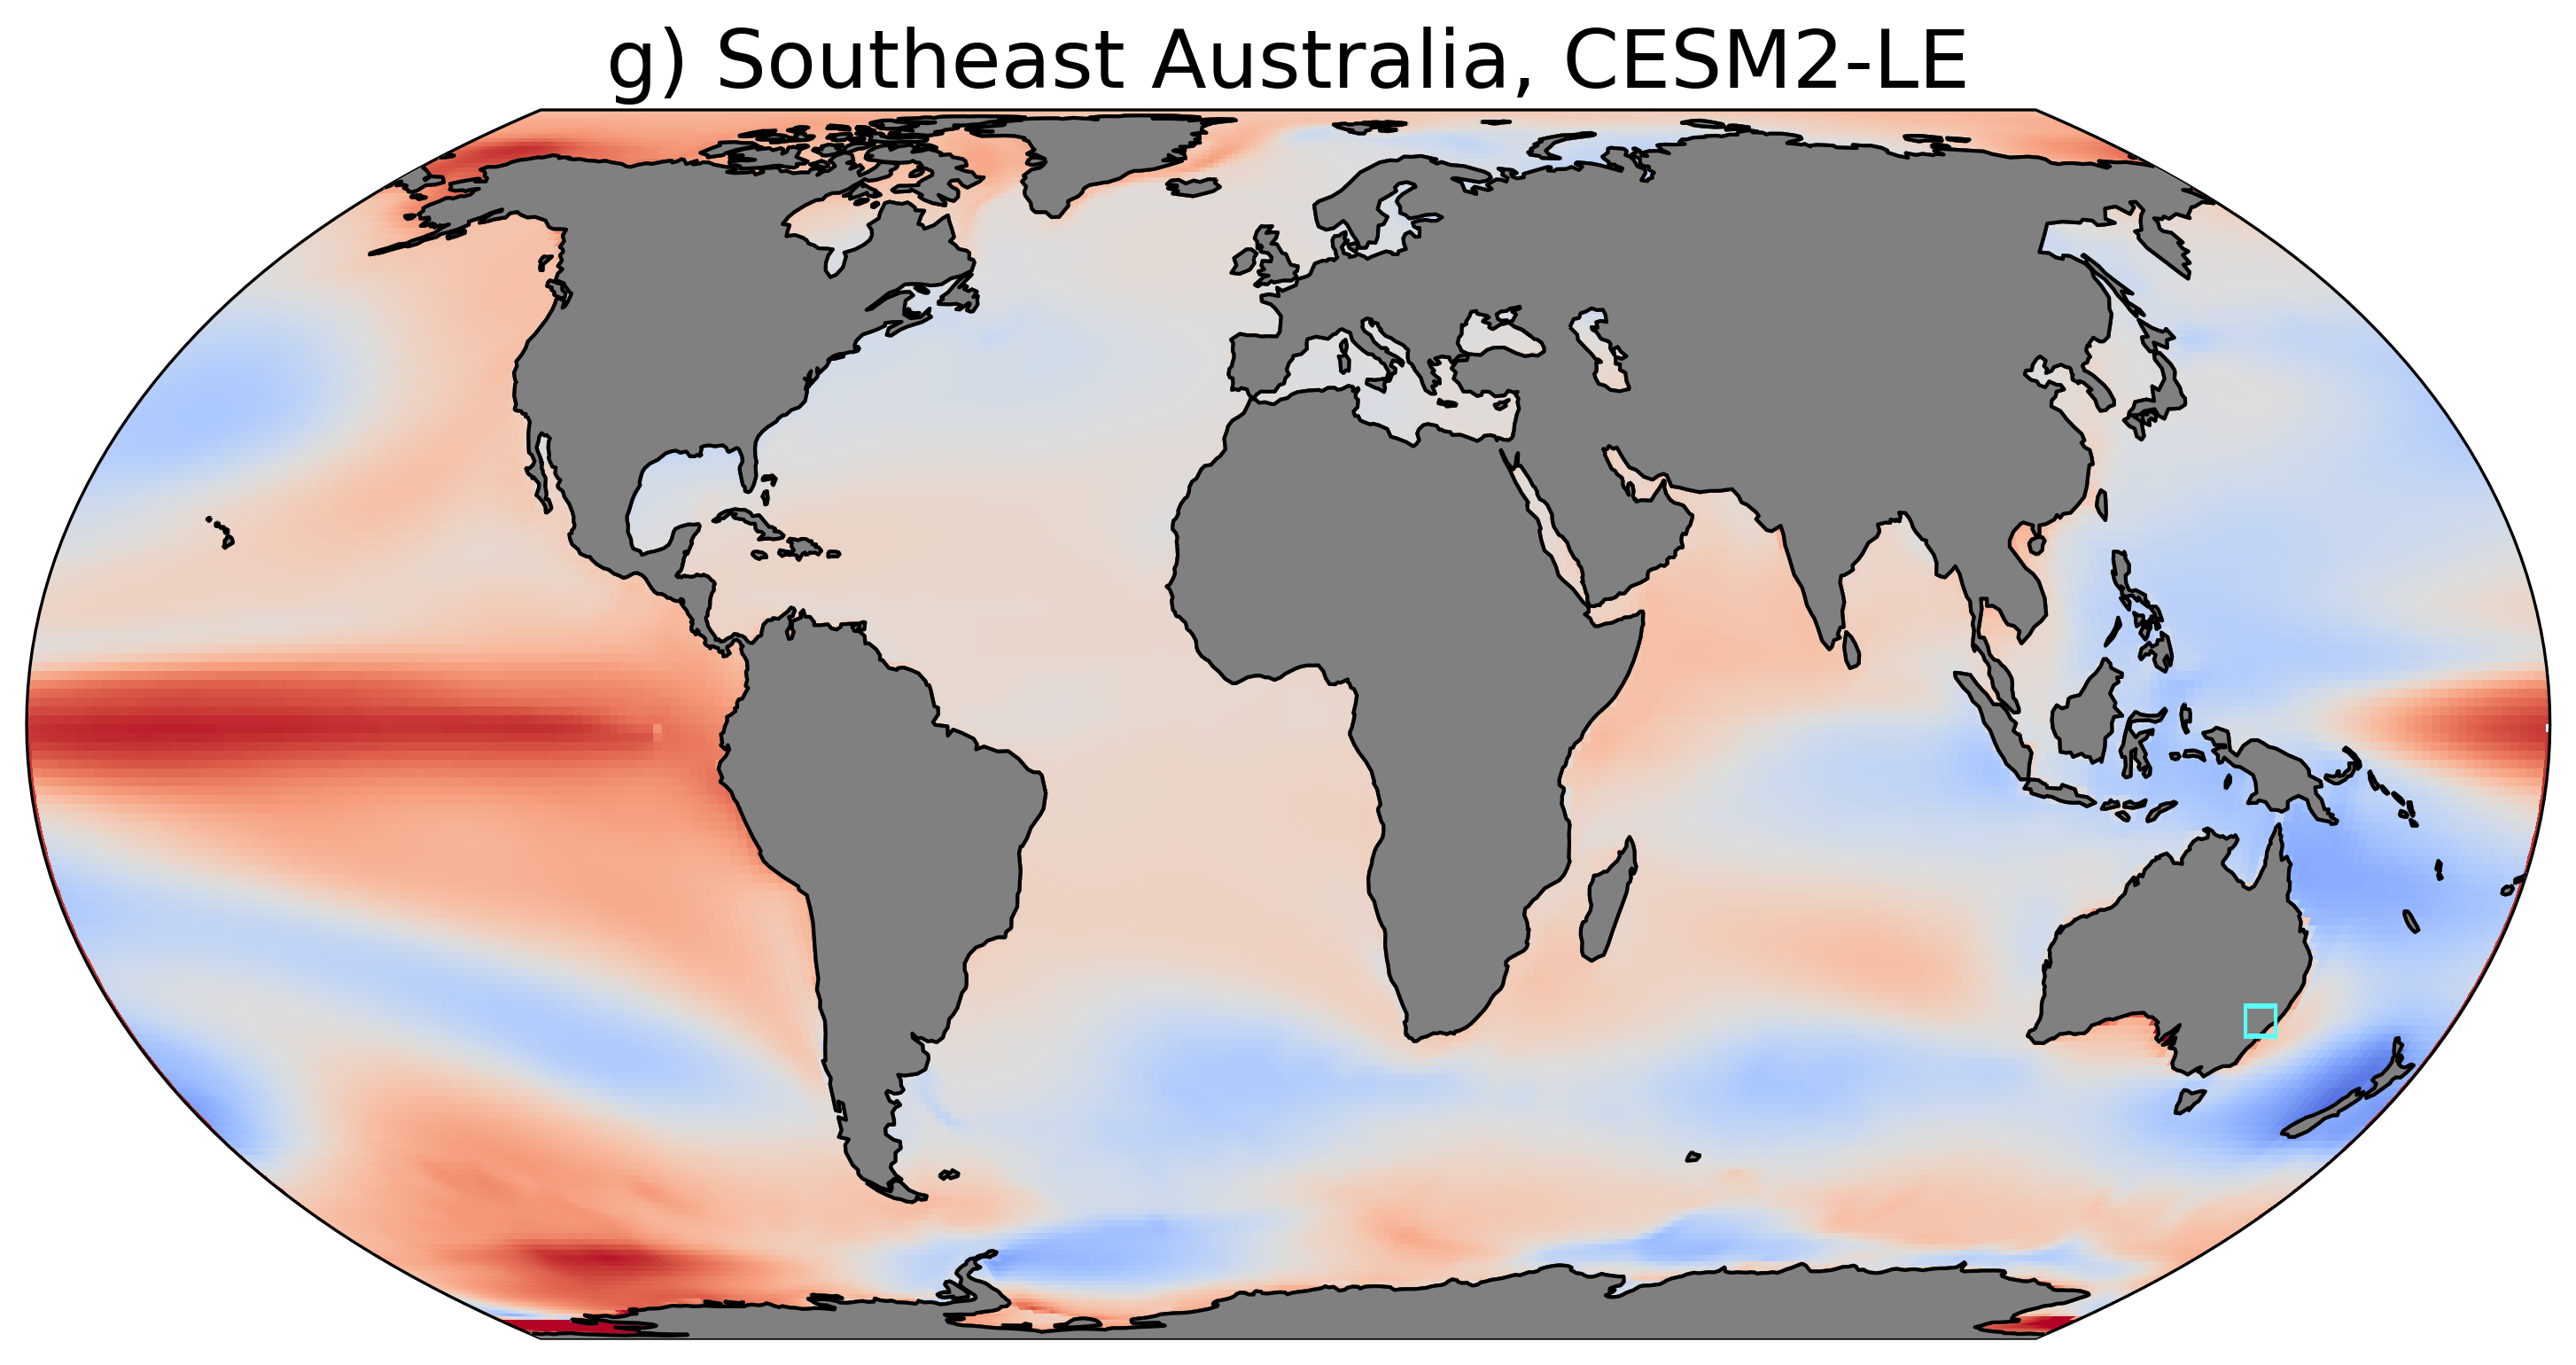

In [8]:
## DEFINE LOCATION COORDIANTES ##
lat_c_comp = -32.51
lon_c_comp = 150

## SORTING TS FILES TO MATCH TREFHT AND PRECT ##
# Function to extract the numerical value from the filename
def extract_number(filename):
    match = re.search(r'\d{3,4}\.\d{3}', filename)
    if match:
        return tuple(map(int, match.group().split('.')))
    return (0, 0)  # Default value if no match found

# Sort filenames based on the extracted numerical value
sorted_filenames_ts = sorted(cesm_ts_files, key = extract_number)

## RUN MEAN SST COMPOSITE FUNCTION ##
composite_map_temp, ts_anom_clim = surface_temperature_composite(CES_all_locations_binary_past, lat_c_comp, lon_c_comp, sorted_filenames_ts, ts_avg_past)

## PLOT ##
lon = ts_anom_clim['lon']
lat = ts_anom_clim['lat']

plt.figure(figsize=(14,6))
ax = plt.axes(projection = ccrs.EqualEarth())
plt.pcolormesh(lon, lat, composite_map_temp, transform = ccrs.PlateCarree(), cmap = 'coolwarm', vmin = -1, vmax = 1)
#cbar = plt.colorbar(extend = 'both', orientation = 'horizontal', fraction = 0.05, pad = 0.01)
#cbar.set_label('Temperature Anomaly', size = 16)
ax.coastlines()
plt.title(f"g) Southeast Australia, CESM2-LE", size = 22)
ax.add_feature(cart.feature.LAND, zorder = 100, edgecolor='k', color = 'gray')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
plt.plot(lon_c_comp, lat_c_comp, transform = ccrs.PlateCarree(), marker = 's', color = '#59FFF9', zorder = 101, markersize = 8, markeredgewidth = 1, markerfacecolor = 'none')
plt.show()

In [19]:
composite_map_temp.sel(lat = lat_c_comp, lon = lon_c_comp, method = 'nearest')

<xarray.DataArray 'TS' ()> Size: 4B
array(2.5927725, dtype=float32)
Coordinates:
    time     object 8B 1941-11-30 00:00:00
    lat      float64 8B 52.3
    lon      float64 8B 357.5

SST by larger region

In [17]:
def surface_temperature_composite(members, locations, ts_mems, ts_avg):
    import xarray as xr

    # true_indices_list will store true indices for each member and each location
    # Structure: list of lists of indices per member
    all_true_indices = []

    for mem in members:
        member_indices = []
        for lat, lon in locations:
            # Select the compound event time series at the given location
            ce_at_location = mem.sel(lat=lat, lon=lon, method='nearest')
            print(ce_at_location)
            # Get indices where the event is True
            true_indices = [index for index, value in enumerate(ce_at_location) if value]
            member_indices.extend(true_indices)  # Combine all indices for this member
        all_true_indices.append(member_indices)

    # Now calculate composite SST anomaly
    temp_sum = 0
    total_count = 0

    for i, file in enumerate(ts_mems):
        # Open dataset and compute anomalies
        ts_anom = xr.open_dataset(file)["TS"] - 273.15
        ts_anom = ts_anom - ts_avg

        # For each true index across all gridpoints for this member
        for t_index in all_true_indices[i]:
            temp_sum += ts_anom.isel(time=t_index)
            total_count += 1

    # Average the anomaly maps
    composite_map_temperature = temp_sum / total_count
    print(total_count)
    return composite_map_temperature, ts_anom

## SORTING TS FILES TO MATCH TREFHT AND PRECT ##
# Function to extract the numerical value from the filename
def extract_number(filename):
    match = re.search(r'\d{3,4}\.\d{3}', filename)
    if match:
        return tuple(map(int, match.group().split('.')))
    return (0, 0)  # Default value if no match found

# Sort filenames based on the extracted numerical value
sorted_filenames_ts = sorted(cesm_ts_files, key = extract_number)

locations = [(-32.51, 150), (-32.51, 151), (-31.80, 151), (-31.80, 150)]  # (lat, lon) tuples
composite_map, last_anom = surface_temperature_composite(CES_all_locations_binary_past, locations, sorted_filenames_ts, ts_avg_past)

## PLOT ##
lon = ts_anom_clim['lon']
lat = ts_anom_clim['lat']

plt.figure(figsize=(14,6))
ax = plt.axes(projection = ccrs.EqualEarth(central_longitude=180))
plt.pcolormesh(lon, lat, composite_map, transform = ccrs.PlateCarree(), cmap = 'coolwarm', vmin = -1, vmax = 1)
#cbar = plt.colorbar(extend = 'both', orientation = 'horizontal', fraction = 0.05, pad = 0.01)
#cbar.set_label('Temperature Anomaly', size = 16)
ax.coastlines()
plt.title(f"Southeast Australia (Average), CESM2-LE", size = 22)
ax.add_feature(cart.feature.LAND, zorder = 100, edgecolor='k', color = 'gray')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')
plt.plot(locations[0][1], locations[0][0], transform = ccrs.PlateCarree(), marker = 's', color = '#59FFF9', zorder = 101, markersize = 10, markeredgewidth = 2, markerfacecolor = 'none')
plt.show()

<xarray.DataArray 'TREFHT' (time: 1008)> Size: 4kB
[1008 values with dtype=float32]
Coordinates:
  * time     (time) object 8kB 1940-01-31 00:00:00 ... 2023-12-31 00:00:00
    lat      float64 8B -32.51
    lon      float64 8B 150.0
    member   int64 8B 0
<xarray.DataArray 'TREFHT' (time: 1008)> Size: 4kB
[1008 values with dtype=float32]
Coordinates:
  * time     (time) object 8kB 1940-01-31 00:00:00 ... 2023-12-31 00:00:00
    lat      float64 8B -32.51
    lon      float64 8B 151.2
    member   int64 8B 0
<xarray.DataArray 'TREFHT' (time: 1008)> Size: 4kB
[1008 values with dtype=float32]
Coordinates:
  * time     (time) object 8kB 1940-01-31 00:00:00 ... 2023-12-31 00:00:00
    lat      float64 8B -31.57
    lon      float64 8B 151.2
    member   int64 8B 0
<xarray.DataArray 'TREFHT' (time: 1008)> Size: 4kB
[1008 values with dtype=float32]
Coordinates:
  * time     (time) object 8kB 1940-01-31 00:00:00 ... 2023-12-31 00:00:00
    lat      float64 8B -31.57
    lon      float64 8B 15

KeyboardInterrupt: 